import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from matplotlib import colors


In [1]:
# how to print using multile code lines??

a = 1
b = 2
name = "Mate"
print("This is attempt to use print" \
" over multiple lines." \
"I have some variables: {}, {}, {}".format(a, b, name))

This is attempt to use print over multiple lines.I have some variables: 1, 2, Mate


In [7]:
def example_function(a, b, c, name):
    print(
        "This is attempt to use print "
        "over multiple lines. "
        "\nI have some variables: {}, {}, {}. ".format(a, b, name)
        + f"Oh, I forgot about variable c; its value is {c}."
    )

# how to call the function using multiple lines?
example_function(
    a=a,
    b=b,
    c=3,
    name=name
)


This is attempt to use print over multiple lines. 
I have some variables: 1, 2, Mate. Oh, I forgot about variable c; its value is 3.


visualisation warm-up: lets plot matrix with imshow

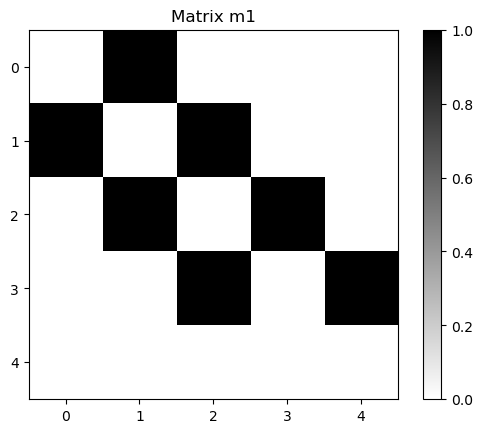

In [ ]:
m1 = np.array([[1,0.7],[0,0.5]])

m2 = np.array([[0, 1, 0, 0, 0],
              [1, 0, 1, 0, 0],
              [0, 1, 0, 1, 0],
              [0, 0, 1, 0, 1],
              [0, 0, 0, 0, 0]])

M = m2
# Create a custom colormap: 0 is white, 1 is black, values in between are interpolated (darker = higher)
cmap = colors.LinearSegmentedColormap.from_list('custom_bw', ['white', 'black'])
plt.imshow(M, cmap=cmap, interpolation='nearest', vmin=0, vmax=1)
plt.colorbar()
plt.title('Matrix m1')
plt.show()




define matrix of tissue with healthy (H) and tumor (T) cells

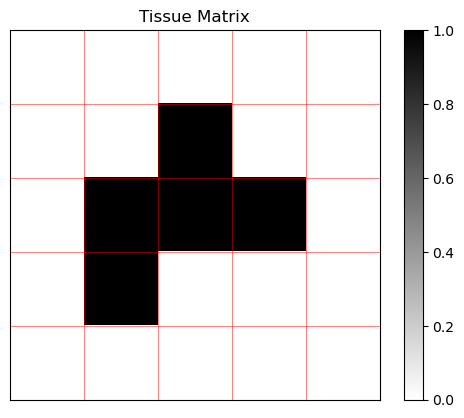

In [7]:
"""
# Tissue matrix representing tumor and healthy cells
- 0 = healthy cell
- 1 = tumor cell
"""
TissueMatrix = np.array([[0, 0, 0, 0, 0],
                         [0, 0, 1, 0, 0],   
                            [0, 1, 1, 1, 0],
                            [0, 1, 0, 0, 0],
                            [0, 0, 0, 0, 0]])

# upscale (optional)
#TissueMatrix = upscale_matrix(TissueMatrix, 2)

# plot matrix 
cmap = colors.LinearSegmentedColormap.from_list('custom_bw', ['white', 'black'])
plt.imshow(TissueMatrix, cmap=cmap, interpolation='nearest', vmin=0, vmax=1)
plt.colorbar()  
plt.title('Tissue Matrix')
# Draw grid lines to show each cell
ax = plt.gca()
ax.set_xticks(np.arange(-0.5, TissueMatrix.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-0.5, TissueMatrix.shape[0], 1), minor=True)
ax.grid(which='minor', color='red', linestyle='-', linewidth=0.7,alpha=0.5)
ax.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
plt.show()



# 1. Constant beam intensity model (simplest)

define a function that counts healthy cells in each line [i] and column [j] - for simple non-attenuating beams approximation

In [8]:
## mission: count healthy and tumor cells in each row and column of TissueMatrix

def count_healthy_cells(matrix):
    # 0 = healthy, 1 = tumor
    matrix = np.array(matrix)
    healthy_in_rows = np.sum(matrix == 0, axis=1)
    healthy_in_cols = np.sum(matrix == 0, axis=0)
    return np.concatenate([healthy_in_rows, healthy_in_cols])

def count_tumor_cells(matrix):
    # 0 = healthy, 1 = tumor
    matrix = np.array(matrix)
    tumor_in_rows = np.sum(matrix == 1, axis=1)
    tumor_in_cols = np.sum(matrix == 1, axis=0)
    return np.concatenate([tumor_in_rows, tumor_in_cols])

# test on our TissueMatrix
NumHealthyRC = count_healthy_cells(TissueMatrix)  # rows, columns
NumTumorRC = count_tumor_cells(TissueMatrix)
print("Healthy cells in rows and columns:", NumHealthyRC)
print("Tumor cells in rows and columns:  ", NumTumorRC)


Healthy cells in rows and columns: [5 4 2 4 5 5 3 3 4 5]
Tumor cells in rows and columns:   [0 1 3 1 0 0 2 2 1 0]


find positions (double index) of tumor cells

In [9]:
def CountIndicesTH(TissueMatrix):
    """
    Given a tissue matrix (0=healthy, 1=tumor), returns:
      - TumorPositions: array of (i, j) indices where tumor cells are present
      - TumorBeamMatrix: matrix mapping each tumor cell to its row and column beams - use for linear programming
      - HealthyPositions: array of (i, j) indices where healthy cells are present
      - HealthyBeamMatrix: matrix mapping each healthy cell to its row and column beams - use for linear programming
    """
    matrix = np.array(TissueMatrix)
    tumor_positions = np.argwhere(matrix == 1)
    healthy_positions = np.argwhere(matrix == 0)
    Nrows, Ncols = matrix.shape
    num_tumor_cells = tumor_positions.shape[0]
    num_healthy_cells = healthy_positions.shape[0]
    num_beams = Nrows + Ncols

    tumor_beam_matrix = np.zeros((num_tumor_cells, num_beams), dtype=int)
    for idx, (i, j) in enumerate(tumor_positions):
        tumor_beam_matrix[idx, i] = 1
        tumor_beam_matrix[idx, Nrows + j] = 1

    healthy_beam_matrix = np.zeros((num_healthy_cells, num_beams), dtype=int)
    for idx, (i, j) in enumerate(healthy_positions):
        healthy_beam_matrix[idx, i] = 1
        healthy_beam_matrix[idx, Nrows + j] = 1

    return {
        "TumorPositions": tumor_positions,
        "TumorBeamMatrix": tumor_beam_matrix,
        "HealthyPositions": healthy_positions,
        "HealthyBeamMatrix": healthy_beam_matrix
    }

# Example usage:
result = CountIndicesTH(TissueMatrix)
print(result)


{'TumorPositions': array([[1, 2],
       [2, 1],
       [2, 2],
       [2, 3],
       [3, 1]], dtype=int64), 'TumorBeamMatrix': array([[0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 1, 0, 0, 0]]), 'HealthyPositions': array([[0, 0],
       [0, 1],
       [0, 2],
       [0, 3],
       [0, 4],
       [1, 0],
       [1, 1],
       [1, 3],
       [1, 4],
       [2, 0],
       [2, 4],
       [3, 0],
       [3, 2],
       [3, 3],
       [3, 4],
       [4, 0],
       [4, 1],
       [4, 2],
       [4, 3],
       [4, 4]], dtype=int64), 'HealthyBeamMatrix': array([[1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
       

now lin.prog. - minimize D_tot to healthy cells, constraints are D_T >= 100

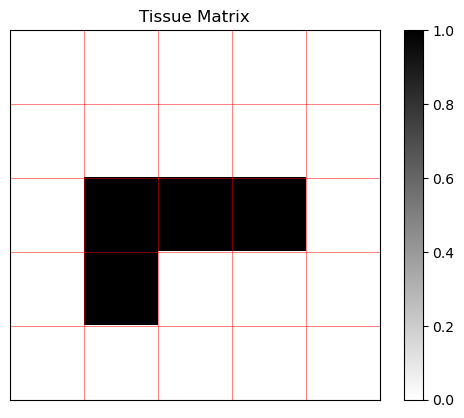

c_minimize: [5 5 2 4 5 5 3 4 4 5]


In [10]:
"""
# Tissue matrix representing tumor and healthy cells
- 0 = healthy cell
- 1 = tumor cell
"""
TissueMatrix = np.array([[0, 0, 0, 0, 0],
                         [0, 0, 0, 0, 0],   
                            [0, 1, 1, 1, 0],
                            [0, 1, 0, 0, 0],
                            [0, 0, 0, 0, 0]])

# upscale TissueMatrix to make it more visible
#TissueMatrix = upscale_matrix(TissueMatrix, 3)
#TissueMatrix[9+6,9+1] = 1  # add tumor cell at (11, 10) for testing

# plot matrix 
cmap = colors.LinearSegmentedColormap.from_list('custom_bw', ['white', 'black'])
plt.imshow(TissueMatrix, cmap=cmap, interpolation='nearest', vmin=0, vmax=1)
plt.colorbar()  
plt.title('Tissue Matrix')
# Draw grid lines to show each cell
ax = plt.gca()
ax.set_xticks(np.arange(-0.5, TissueMatrix.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-0.5, TissueMatrix.shape[0], 1), minor=True)
ax.grid(which='minor', color='red', linestyle='-', linewidth=0.7,alpha=0.5)
ax.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
plt.show()

# define shape of TissueMatrix
Nrows, Ncols = TissueMatrix.shape

"""
Lets explain in more detail how we will use linear programming to solve this problem:
1. We are irradiatin tissue matrix with radiation beams. 
2. Tissue shape is (at least for now) rectangular matrix with rows and columns - (Nrows, Ncols).
3. Beams are narrow ("pencil-like") and can be placed along rows and columns of the matrix.
4. Each beam will irradiate all cells in its row and column - and nothing else (no scatter ect).
5. Beams in our first example are placed only left from and above the tumor cells - so we have Nrows + Ncols beams. 
5. We will use linear programming to optimize the beam intensities such that:
    - tumor cells receive at least a minimum dose of radiation (MinDoseTumorCells) 
    - healthy cells receive no more than a maximum dose of radiation (MaxDoseHealthyCells)
6. The objective function will minimize the total dose to healthy cells, which is represented by the cost function coefficients (c vector).
7. The constraints will ensure that tumor cells receive the required minimum dose and healthy cells do not exceed the maximum dose.
8. We are searching for beam intensities that satisfy these conditions, lets denote them as BeamIntensities.
9. BeamIntensities will be a vector of length Nrows + Ncols, where each element represents the intensity of a beam.
10. The solution will provide the optimal beam intensities that satisfy these conditions.
"""

# define c vector for linprog
# c vector is the cost function coefficients
# in our case it minimizes total dose to healthy cells - it counts healthy cells in each row and column
c_minimize = count_healthy_cells(TissueMatrix)
print("c_minimize:", c_minimize)

# define A_ub and b_ub for linprog
# A_ub will repesent the constraints for tumor and healthy cells doses
# - tumor cells must receive at least MinDoseTumorCells units of radiation
# - healthy cells must not receive more than MaxDoseHealthyCells units of radiation
MinDoseTumorCells = 100
MaxDoseHealthyCells = 70
# count tumor and healthy cells in TissueMatrix
# we will use CountIndicesTH function to get TumorBeamMatrix and HealthyBeamMatrix
countcells = CountIndicesTH(TissueMatrix)
TumorBeamMatrix = countcells["TumorBeamMatrix"]
HealthyBeamMatrix = countcells["HealthyBeamMatrix"]
TumorPositions = countcells["TumorPositions"]
HealthyPositions = countcells["HealthyPositions"]   

# tumor constraints
Aub_Tumor = - TumorBeamMatrix
bub_Tumor = - np.ones(TumorBeamMatrix.shape[0]) * MinDoseTumorCells
# healthy constraints 
Aub_Healthy = HealthyBeamMatrix
bub_Healthy = np.ones(HealthyBeamMatrix.shape[0]) * MaxDoseHealthyCells
# combine tumor and healthy constraints
Aub = np.vstack((Aub_Tumor, Aub_Healthy))   
bub = np.concatenate((bub_Tumor, bub_Healthy))


### NO NEED OF BOUNDS HERE!
# define bounds for linprog
bounds = [(0, None)] * len(c_minimize)
# print bounds
#print("Bounds:", bounds)



find the linprog optimal solution for irradiation

In [11]:
# solve the linear programming problem
result = linprog(c=c_minimize, A_ub=Aub, b_ub=bub, bounds=bounds, method='highs')
DH_tot = result.fun  # optimal value of the objective function = total dose to healthy cells
OptimalBeamIntensities = result.x  # optimal beam intensities

# report the results
if result.success:
    print("Optimal value:", DH_tot)
    print("Optimal solution:", OptimalBeamIntensities)
else:
    print("Optimization failed:", result.message)



Optimal value: 710.0
Optimal solution: [ 0.  0. 70. 30.  0.  0. 70. 30. 30.  0.]


plot the tissue irradiation

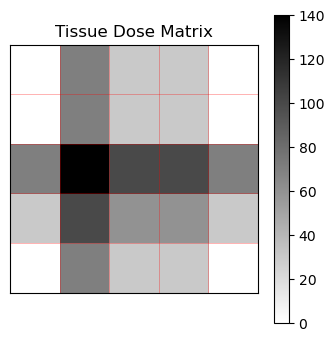

In [12]:
# Now we have the optimal beam intensities, we can calculate the dose distribution in the tissue matrix.
# We will create a new matrix TissueDoseMatrix that will represent the dose received by each tissue
TissueDoseMatrix = np.zeros_like(TissueMatrix, dtype=float)
for i in range(Nrows):
    for j in range(Ncols):
        # Add the intensity of the beams to the corresponding tissue cells
        # BeamsIntensity[i] corresponds to row i, BeamsIntensity[j+5] corresponds to column j
        TissueDoseMatrix[i, j] += OptimalBeamIntensities[i] + OptimalBeamIntensities[j+Nrows]

# plot TissueDoseMatrix with black=high dose, white=low dose, and visible cell borders
cmap_bw = colors.LinearSegmentedColormap.from_list('custom_bw', ['white', 'black'])
plt.figure(figsize=(4, 4))
plt.imshow(TissueDoseMatrix, cmap=cmap_bw, interpolation='nearest', vmin=np.min(TissueDoseMatrix), vmax=np.max(TissueDoseMatrix))
plt.colorbar()
plt.title('Tissue Dose Matrix')

# Draw grid lines to show each cell
ax = plt.gca()
ax.set_xticks(np.arange(-0.5, Ncols, 1), minor=True)
ax.set_yticks(np.arange(-0.5, Nrows, 1), minor=True)
ax.grid(which='minor', color='red', linestyle='-', linewidth=0.7,alpha=.3)
ax.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

plt.show()



Visualize the tissue matrix with more information:


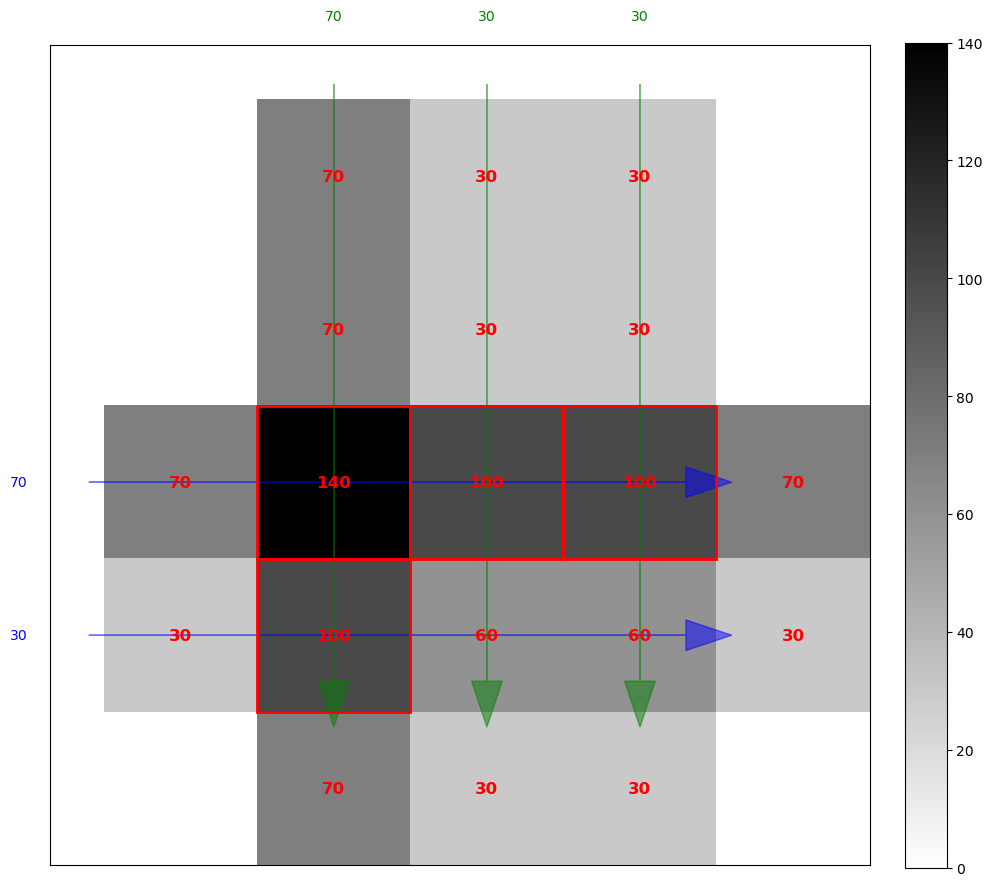

In [13]:
# Visualize the tissue matrix with more information:
# - Show the dose in each cell (if nonzero)
# - Overlay arrows for beams with nonzero intensity, indicating their direction and position

fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(TissueDoseMatrix, cmap=cmap_bw, interpolation='nearest', vmin=0, vmax=np.max(TissueDoseMatrix))

# Annotate each cell with its dose (if nonzero)
for i in range(Nrows):
    for j in range(Ncols):
        dose = TissueDoseMatrix[i, j]
        if dose > 0:
            ax.text(j, i, f"{dose:.0f}", ha='center', va='center', color='red', fontsize=12, fontweight='bold')

# Overlay beam directions for nonzero beams
# Row beams (horizontal, left to right)
for i in range(Nrows):
    if OptimalBeamIntensities[i] > 0.0:
        ax.arrow(-0.6, i, Ncols-0.8, 0, head_width=0.2, head_length=0.3, fc='blue', ec='blue', length_includes_head=True, alpha=0.5)
        ax.text(-1, i, f"{OptimalBeamIntensities[i]:.0f}", color='blue', va='center', ha='right', fontsize=10)

# Column beams (vertical, top to bottom)
for j in range(Ncols):
    idx = Nrows + j
    if OptimalBeamIntensities[idx] > 0:
        ax.arrow(j, -0.6, 0, Nrows-0.8, head_width=0.2, head_length=0.3, fc='green', ec='green', length_includes_head=True, alpha=0.5)
        ax.text(j, -1, f"{OptimalBeamIntensities[idx]:.0f}", color='green', ha='center', va='bottom', fontsize=10)

# # Draw blue grid lines for all cells
# for i in range(Nrows + 1):
#     ax.axhline(i - 0.5, color='blue', linewidth=1, alpha=0.7)
# for j in range(Ncols + 1):
#     ax.axvline(j - 0.5, color='blue', linewidth=1, alpha=0.7)

# Highlight tumor cells with a red rectangle
for pos in TumorPositions:
    rect = plt.Rectangle((pos[1] - 0.5, pos[0] - 0.5), 1, 1, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

# Formatting
#ax.set_xticks(np.arange(Ncols))
#ax.set_yticks(np.arange(Nrows))
#ax.set_xticklabels(np.arange(Ncols))
#ax.set_yticklabels(np.arange(Nrows))
ax.set_xticks([])
ax.set_yticks([])
#ax.set_title('Dose per cell and active beam directions')
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()


statistical analysis

In [14]:
# Calculate average dose to tumor (T) and healthy (H) cells
tumor_mask = (TissueMatrix == 1)
healthy_mask = (TissueMatrix == 0)

avg_dose_tumor = TissueDoseMatrix[tumor_mask].mean()
avg_dose_healthy = TissueDoseMatrix[healthy_mask].mean()

print(f"Average dose to tumor cells: {avg_dose_tumor:.2f}")
print(f"Average dose to healthy cells: {avg_dose_healthy:.2f}")



Average dose to tumor cells: 110.00
Average dose to healthy cells: 33.81


Class TissueIrradiation

In [44]:
class TissueIrradiationConstant:
    def __init__(self, tissue_matrix, min_dose_tumor=100, max_dose_healthy=None):
        self.tissue_matrix = np.array(tissue_matrix)
        self.min_dose_tumor = min_dose_tumor
        self.max_dose_healthy = max_dose_healthy
        self.nrows, self.ncols = self.tissue_matrix.shape
        self.cmap = colors.LinearSegmentedColormap.from_list('custom_bw', ['white', 'black'])
        self._count_cells()
        self._build_c_minimize()
        self._find_indices_and_beam_matrices()
        self.optimized = False

    def plot_tissue(self):
        plt.imshow(self.tissue_matrix, cmap=self.cmap, interpolation='nearest', vmin=0, vmax=1)
        plt.colorbar()
        plt.title('Tissue Matrix')
        ax = plt.gca()
        ax.set_xticks(np.arange(-0.5, self.ncols, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, self.nrows, 1), minor=True)
        ax.grid(which='minor', color='red', linestyle='-', linewidth=0.7, alpha=0.5)
        ax.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
        plt.show()

    def _count_cells(self):
        self.healthy_in_rows = np.sum(self.tissue_matrix == 0, axis=1)
        self.healthy_in_cols = np.sum(self.tissue_matrix == 0, axis=0)
        self.tumor_in_rows = np.sum(self.tissue_matrix == 1, axis=1)
        self.tumor_in_cols = np.sum(self.tissue_matrix == 1, axis=0)

    def _build_c_minimize(self):
        # Minimize total dose to healthy cells
        self.c_minimize = np.concatenate([self.healthy_in_rows, self.healthy_in_cols])

    def _find_indices_and_beam_matrices(self):
        matrix = self.tissue_matrix
        tumor_positions = np.argwhere(matrix == 1)
        healthy_positions = np.argwhere(matrix == 0)
        n_beams = self.nrows + self.ncols

        tumor_beam_matrix = np.zeros((len(tumor_positions), n_beams), dtype=int)
        for idx, (i, j) in enumerate(tumor_positions):
            tumor_beam_matrix[idx, i] = 1
            tumor_beam_matrix[idx, self.nrows + j] = 1

        healthy_beam_matrix = np.zeros((len(healthy_positions), n_beams), dtype=int)
        for idx, (i, j) in enumerate(healthy_positions):
            healthy_beam_matrix[idx, i] = 1
            healthy_beam_matrix[idx, self.nrows + j] = 1

        self.tumor_positions = tumor_positions
        self.healthy_positions = healthy_positions
        self.tumor_beam_matrix = tumor_beam_matrix
        self.healthy_beam_matrix = healthy_beam_matrix

    def optimize(self,doReport =False):
        # Constraints for tumor cells (at least min_dose_tumor)
        Aub_tumor = -self.tumor_beam_matrix
        bub_tumor = -np.ones(self.tumor_beam_matrix.shape[0]) * self.min_dose_tumor
        # Constraints for healthy cells (at most max_dose_healthy)
        if self.max_dose_healthy is not None:
            Aub_healthy = self.healthy_beam_matrix
            bub_healthy = np.ones(self.healthy_beam_matrix.shape[0]) * self.max_dose_healthy
            Aub = np.vstack((Aub_tumor, Aub_healthy))
            bub = np.concatenate((bub_tumor, bub_healthy))
        else:
            Aub = Aub_tumor
            bub = bub_tumor
        bounds = [(0, None)] * len(self.c_minimize)

        result = linprog(c=self.c_minimize, A_ub=Aub, b_ub=bub, bounds=bounds, method='highs')
        self.result = result
        if result.success:
            print("Optimization successful.")
            self.optimal_beam_intensities = result.x
            self.DH_tot = result.fun
            self.optimized = True
            # calculate dose distribution
            self.calculate_dose_distribution()
            if doReport:
                print("Optimal value:", result.fun)
                print("Optimal solution:", result.x)    

        else:
            print("Optimization failed:", result.message)
            self.optimal_beam_intensities = None
            self.DH_tot = None
            self.optimized = False

    def calculate_dose_distribution(self):
        if not self.optimized:
            print("Run optimize() first.")
            return

        dose_matrix = np.zeros_like(self.tissue_matrix, dtype=float)
        for i in range(self.nrows):
            for j in range(self.ncols):
                dose_matrix[i, j] = self.optimal_beam_intensities[i] + self.optimal_beam_intensities[self.nrows + j]
        self.tissue_dose_matrix = dose_matrix

    def plot_irradiation_scheme(self):
        if self.optimal_beam_intensities is None:
            print("Run optimize() first.")
            return
        if not hasattr(self, 'tissue_dose_matrix'):
            return

        fig, ax = plt.subplots(figsize=(8, 8))
        im = ax.imshow(self.tissue_dose_matrix, cmap=self.cmap, interpolation='nearest', 
                       vmin=np.min(self.tissue_dose_matrix), vmax=np.max(self.tissue_dose_matrix),
                       extent=[-0.5, self.ncols-0.5, self.nrows-0.5, -0.5])

        # Draw grid lines for cells (only at cell boundaries)
        ax.set_xticks(np.arange(-0.5, self.ncols, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, self.nrows, 1), minor=True)
        ax.grid(which='minor', color='black', linestyle='-', linewidth=1, alpha=0.5)
        ax.set_xlim(-0.5, self.ncols-0.5)
        ax.set_ylim(self.nrows-0.5, -0.5)

        # Annotate each cell with its dose (if nonzero)
        for i in range(self.nrows):
            for j in range(self.ncols):
                dose = self.tissue_dose_matrix[i, j]
                if dose > 0:
                    ax.text(j, i, f"{dose:.0f}", ha='center', va='center', color='red', fontsize=12, fontweight='bold')

        # Highlight tumor cells with red edges
        tumor_mask = (self.tissue_matrix == 1)
        for (i, j) in np.argwhere(tumor_mask):
            rect = plt.Rectangle((j-0.5, i-0.5), 1, 1, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)

        # Highlight tissue edges
        ax.plot([-0.5, self.ncols-0.5], [-0.5, -0.5], color='black', linewidth=2)
        ax.plot([-0.5, self.ncols-0.5], [self.nrows-0.5, self.nrows-0.5], color='black', linewidth=2)
        ax.plot([-0.5, -0.5], [-0.5, self.nrows-0.5], color='black', linewidth=2)
        ax.plot([self.ncols-0.5, self.ncols-0.5], [-0.5, self.nrows-0.5], color='black', linewidth=2)

        # Draw beams: horizontal (rows) and vertical (cols) with smaller arrows at the edges
        arrow_length = 0.7
        arrow_head_width = 0.12
        arrow_head_length = 0.12

        for beam_idx in range(self.nrows):
            intensity = self.optimal_beam_intensities[beam_idx] if hasattr(self, 'optimal_beam_intensities') else None
            if intensity is not None and intensity > 0:
                # Left edge arrow for row beams
                ax.arrow(-0.9, beam_idx, arrow_length, 0, head_width=arrow_head_width, head_length=arrow_head_length,
                         fc='blue', ec='blue', linewidth=1.2, length_includes_head=True, zorder=10)
                ax.text(-0.9, beam_idx, f"{intensity:.0f}", va='center', ha='right', color='blue', fontsize=11)
                # Right edge arrow for row beams
                ax.arrow(self.ncols-0.3, beam_idx, arrow_length, 0, head_width=arrow_head_width, head_length=arrow_head_length,
                         fc='blue', ec='blue', linewidth=1.2, length_includes_head=True, zorder=10)

        for beam_idx in range(self.ncols):
            intensity = self.optimal_beam_intensities[self.nrows + beam_idx] if hasattr(self, 'optimal_beam_intensities') else None
            if intensity is not None and intensity > 0:
                # Top edge arrow for column beams
                ax.arrow(beam_idx, -0.9, 0, arrow_length, head_width=arrow_head_width, head_length=arrow_head_length,
                         fc='green', ec='green', linewidth=1.2, length_includes_head=True, zorder=10)
                ax.text(beam_idx, -0.9, f"{intensity:.0f}", va='bottom', ha='center', color='green', fontsize=11)
                # Bottom edge arrow for column beams
                ax.arrow(beam_idx, self.nrows-0.3, 0, arrow_length, head_width=arrow_head_width, head_length=arrow_head_length,
                         fc='green', ec='green', linewidth=1.2, length_includes_head=True, zorder=10)

        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
        plt.show()

    def report_statistics(self):
        # place for code for checking if tissue_dose_matrix is calculated
        if not hasattr(self, 'tissue_dose_matrix'):
            print("Run calculate_dose_distribution() first.")
            return
        tumor_mask = (self.tissue_matrix == 1)
        healthy_mask = (self.tissue_matrix == 0)
        avg_dose_tumor = self.tissue_dose_matrix[tumor_mask].mean() if np.any(tumor_mask) else 0
        avg_dose_healthy = self.tissue_dose_matrix[healthy_mask].mean() if np.any(healthy_mask) else 0
        print(f"Average dose to tumor cells: {avg_dose_tumor:.2f}")
        print(f"Average dose to healthy cells: {avg_dose_healthy:.2f}")

        

In [ ]:
# test the class
tissue_matrix = np.array([[0, 0, 0, 0, 0],
                           [0, 0, 0, 0, 0],   
                           [0, 1, 1, 0, 0],
                           [0, 1, 0, 0, 0],
                           [0, 0, 0, 0, 0]])

# upscale
upscale_factor = 2
tissue_matrix = upscale_matrix(tissue_matrix, upscale_factor)

MaxDoseHealthyCells = 70
tissue_irradiation = TissueIrradiationConstant(tissue_matrix,max_dose_healthy=MaxDoseHealthyCells)
tissue_irradiation.plot_tissue()
# optimize
tissue_irradiation.optimize(doReport=True)

# plot and report 
tissue_irradiation.plot_irradiation_scheme()
tissue_irradiation.report_statistics()


---
---
# New classes definition, separate classes into problem definition and solving (mistake??)
---

In [ ]:
class TissueIrradiationProblem:
    def __init__(self, tissue_matrix, min_dose_tumor=100, max_dose_healthy=None,beam_type='constant', lac=1):
        self.tissue_matrix = np.array(tissue_matrix)
        self.min_dose_tumor = min_dose_tumor
        self.max_dose_healthy = max_dose_healthy
        self.nrows, self.ncols = self.tissue_matrix.shape
        self._analyze_tissue()
        self._build_problem(beam_type=beam_type, lac=lac)

    def plot_tissue(self):
        cmap = colors.LinearSegmentedColormap.from_list('custom_bw', ['white', 'black'])
        plt.imshow(self.tissue_matrix, cmap=cmap, interpolation='nearest', vmin=0, vmax=1)
        plt.colorbar()
        plt.title('Tissue Matrix')
        ax = plt.gca()
        ax.set_xticks(np.arange(-0.5, self.ncols, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, self.nrows, 1), minor=True)
        ax.grid(which='minor', color='red', linestyle='-', linewidth=0.7, alpha=0.5)
        ax.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
        plt.show()

    def _analyze_tissue(self):
        self.tumor_positions = np.argwhere(self.tissue_matrix == 1)
        self.healthy_positions = np.argwhere(self.tissue_matrix == 0)
        self.n_tumor = len(self.tumor_positions)
        self.n_healthy = len(self.healthy_positions)
        self.n_beams = self.nrows + self.ncols

    def _build_problem(self,beam_type='constant', lac=1):
        # c: minimize total dose to healthy cells
        healthy_in_rows = np.sum(self.tissue_matrix == 0, axis=1)
        healthy_in_cols = np.sum(self.tissue_matrix == 0, axis=0)
        
        if beam_type == 'constant':
            print("Using constant intensity beam model.")
            c_beams = np.concatenate([healthy_in_rows, healthy_in_cols])
            # A_ub and b: constraints for tumor cells
            tumor_beam_matrix = np.zeros((self.n_tumor, self.n_beams), dtype=int)
            for idx, (i, j) in enumerate(self.tumor_positions):
                tumor_beam_matrix[idx, i] = 1
                tumor_beam_matrix[idx, self.nrows + j] = 1
            A_ub = -tumor_beam_matrix
            b_ub = -np.ones(self.n_tumor) * self.min_dose_tumor
            
            # Add healthy cell constraints if needed
            if self.max_dose_healthy is not None:
                healthy_beam_matrix = np.zeros((self.n_healthy, self.n_beams), dtype=int)
                for idx, (i, j) in enumerate(self.healthy_positions):
                    healthy_beam_matrix[idx, i] = 1
                    healthy_beam_matrix[idx, self.nrows + j] = 1
                A_ub = np.vstack((A_ub, healthy_beam_matrix))
        
        elif beam_type == 'exponential':
            print("Using exponential intensity beam model with linear attenuation coefficient (lac):", lac)
            c_left = np.zeros(self.nrows)
            c_right = np.zeros(self.nrows)
            c_top = np.zeros(self.ncols)
            c_bottom = np.zeros(self.ncols)
            for i in range(self.nrows):
                js = self.healthy_positions[self.healthy_positions[:, 0] == i][:, 1]
                c_left[i] = np.sum(np.exp(-lac*js))
                c_right[i] = np.sum(np.exp(-lac*(self.ncols - js - 1)))
            for j in range(self.ncols):
                is_ = self.healthy_positions[self.healthy_positions[:, 1] == j][:, 0]
                c_top[j] = np.sum(np.exp(-lac*is_)) 
                c_bottom[j] = np.sum(np.exp(-lac*(self.nrows - is_ - 1)))
            c_beams = np.concatenate([c_left, c_right, c_top, c_bottom])

            # A_ub and b: constraints for tumor cells
            Aub = np.zeros((self.n_tumor, 2*self.nrows + 2*self.ncols), dtype=float)
            for idx, (i, j) in enumerate(self.tumor_positions):
                Aub[idx, i] = np.exp(-lac * j)  # contribution from the left beam
                Aub[idx, self.nrows + i] = np.exp(-lac * (self.ncols - j - 1))  # contribution from the right beam
                Aub[idx, 2*self.nrows + j] = np.exp(-lac * i)  # contribution from the above/top beam
                Aub[idx, 2*self.nrows + self.ncols + j] = np.exp(-lac * (self.nrows - i - 1))  # contribution from the bottom/under beam
            if self.max_dose_healthy is not None:
                healthy_Aub = np.zeros((self.n_healthy, 2*self.nrows + 2*self.ncols), dtype=float)
                for idx, (i, j) in enumerate(self.healthy_positions):
                    healthy_Aub[idx, i] = np.exp(-lac * j)
                    healthy_Aub[idx, self.nrows + i] = np.exp(-lac * (self.ncols - j - 1))
                    healthy_Aub[idx, 2*self.nrows + j] = np.exp(-lac * i)
                    healthy_Aub[idx, 2*self.nrows + self.ncols + j] = np.exp(-lac * (self.nrows - i - 1))
                Aub = np.vstack((Aub, healthy_Aub))


        elif beam_type == 'simulated':
            print("Using beam from self simulated data for energy deposition distribution.")
            ####
            a = 2

        elif beam_type in ['proton', 'neutron', 'electron','other_stuff']:
            # Placeholder for other beam types
            raise NotImplementedError(f"Beam type '{beam_type}' is not implemented yet.")
        else:
            raise ValueError(f"Unknown beam type: {beam_type}")

        # make c_beams and A_ub attributes
        self.c_beams = c_beams
        self.A_ub = A_ub
        # add b_ub - same for all beam types
        self.b_ub = -np.ones(self.n_tumor) * self.min_dose_tumor
        # add healthy cell constraints if needed
        if self.max_dose_healthy is not None:
            self.b_ub = np.concatenate((self.b_ub, np.ones(self.n_healthy) * self.max_dose_healthy))
        
        # bound - unnecessary as by default linprog assumes non-negative variables
        #self.bounds = [(0, None)] * len(self.c_beams)


class TissueIrradiationOptimizer:
    def __init__(self, problem_parameters):
        self.problem_parameters = problem_parameters
        self.optimized = False

        # extract parameters from problem_parameters
        self.nrows = problem_parameters["nrows"]
        self.ncols = problem_parameters["ncols"]
        self.tissue_matrix = problem_parameters["tissue_matrix"]
        self.c_beams = problem_parameters["c_beams"]
        self.A_ub = problem_parameters["A_ub"]
        self.b_ub = problem_parameters["b_ub"]

    def optimize(self, doReport=False):        
        result = linprog(c=self.c_beams, A_ub=self.A_ub, b_ub=self.b_ub, method='highs')
        self.result = result
        
        if result.success:
            self.optimal_beam_intensities = result.x
            self.DH_tot = result.fun
            self.optimized = True
            if doReport:
                print("Optimization successful.")
                print("Optimal value:", result.fun)
                print("Optimal solution:", result.x)
                # Calculate dose distribution
                self.calculate_dose_distribution()
        else:
            print("Optimization failed:", result.message)
            self.optimal_beam_intensities = None
            self.DH_tot = None
            self.optimized = False

    def calculate_dose_distribution(self):
        if not self.optimized:
            print("Run optimize() first.")
            return

        dose_matrix = np.zeros_like(self.tissue_matrix, dtype=float)
        for i in range(self.nrows):
            for j in range(self.ncols):
                dose_matrix[i, j] = self.optimal_beam_intensities[i] + self.optimal_beam_intensities[self.nrows + j]
        self.tissue_dose_matrix = dose_matrix

    def plot_irradiation_scheme(self):
        if not self.optimized:
            print("Run optimize() first.")
            return

        fig, ax = plt.subplots(figsize=(8, 8))
        cmap = colors.LinearSegmentedColormap.from_list('custom_bw', ['white', 'black'])
        im = ax.imshow(self.tissue_dose_matrix, cmap=cmap, interpolation='nearest', 
                       vmin=np.min(self.tissue_dose_matrix), vmax=np.max(self.tissue_dose_matrix),
                       extent=[-0.5, self.ncols-0.5, self.nrows-0.5, -0.5])

        # Draw grid lines for cells (only at cell boundaries)
        ax.set_xticks(np.arange(-0.5, self.ncols, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, self.nrows, 1), minor=True)
        ax.grid(which='minor', color='black', linestyle='-', linewidth=1, alpha=0.5)
        ax.set_xlim(-0.5, self.ncols-0.5)
        ax.set_ylim(self.nrows-0.5, -0.5)

        # Annotate each cell with its dose (if nonzero)
        for i in range(self.nrows):
            for j in range(self.ncols):
                dose = self.tissue_dose_matrix[i, j]
                if dose > 0:
                    ax.text(j, i, f"{dose:.0f}", ha='center', va='center', color='red', fontsize=12, fontweight='bold')

        # Highlight tumor cells with red edges
        tumor_mask = (self.tissue_matrix == 1)
        for (i, j) in np.argwhere(tumor_mask):
            rect = plt.Rectangle((j-0.5, i-0.5), 1, 1, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)

        # Highlight tissue edges
        ax.plot([-0.5, self.ncols-0.5], [-0.5, -0.5], color='black', linewidth=2)
        ax.plot([-0.5, self.ncols-0.5], [self.nrows-0.5, self.nrows-0.5], color='black', linewidth=2)
        ax.plot([-0.5, -0.5], [-0.5, self.nrows-0.5], color='black', linewidth=2)
        ax.plot([self.ncols-0.5, self.ncols-0.5], [-0.5, self.nrows-0.5], color='black', linewidth=2)
        # Draw beams: horizontal (rows) and vertical (cols) with smaller arrows at the edges
        arrow_length = 0.7
        arrow_head_width = 0.12
        arrow_head_length = 0.12
        
        ## beam from left and right edges of the tissue matrix
        for beam_idx in range(self.nrows):
            intensity = self.optimal_beam_intensities[beam_idx] if hasattr(self, 'optimal_beam_intensities') else None
            if intensity is not None and intensity > 0:
                # Left edge arrow for row beams
                ax.arrow(-0.9, beam_idx, arrow_length, 0, head_width=arrow_head_width, head_length=arrow_head_length,
                         fc='blue', ec='blue', linewidth=1.2, length_includes_head=True, zorder=10)
                ax.text(-0.9, beam_idx, f"{intensity:.0f}", va='center', ha='right', color='blue', fontsize=11)
                # Right edge arrow for row beams
                ax.arrow(self.ncols-0.3, beam_idx, arrow_length, 0, head_width=arrow_head_width, head_length=arrow_head_length,
                         fc='blue', ec='blue', linewidth=1.2, length_includes_head=True, zorder=10)
                #ax.text(self.ncols-0.3, beam_idx, f"{intensity:.0f}", va='center', ha='left', color='blue', fontsize=11)
        for beam_idx in range(self.ncols):
            intensity = self.optimal_beam_intensities[self.nrows + beam_idx] if hasattr(self, 'optimal_beam_intensities') else None
            if intensity is not None and intensity > 0:
                # Top edge arrow for column beams
                ax.arrow(beam_idx, -0.9, 0, arrow_length, head_width=arrow_head_width, head_length=arrow_head_length,
                         fc='green', ec='green', linewidth=1.2, length_includes_head=True, zorder=10)
                ax.text(beam_idx, -0.9, f"{intensity:.0f}", va='bottom', ha='center', color='green', fontsize=11)
                # Bottom edge arrow for column beams
                ax.arrow(beam_idx, self.nrows-0.3, 0, arrow_length, head_width=arrow_head_width, head_length=arrow_head_length,
                         fc='green', ec='green', linewidth=1.2, length_includes_head=True, zorder=10)
                #ax.text(beam_idx, self.nrows-0.3, f"{intensity:.0f}", va='top', ha='center', color='green', fontsize=11)


        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
        plt.show()

    def report_statistics(self):
        print("Statistics:")
        if not hasattr(self, 'tissue_dose_matrix'): 
            print("Run calculate_dose_distribution() first.")
            return  
        tumor_mask = (self.tissue_matrix == 1)
        healthy_mask = (self.tissue_matrix == 0)
        avg_dose_tumor = self.tissue_dose_matrix[tumor_mask].mean() if np.any(tumor_mask) else 0
        avg_dose_healthy = self.tissue_dose_matrix[healthy_mask].mean() if np.any(healthy_mask) else 0
        print(f"Average dose to tumor cells: {avg_dose_tumor:.2f}")
        print(f"Average dose to healthy cells: {avg_dose_healthy:.2f}")



this is example of drawing beam intensities for all intensities that are more than 0. Now those are from left and from abouve (top). Now i wonder could we make a function that would as argument take number_of_beams, then direction (could be left or top, but also right or bottom - for the latter two, arrow position and directions of course change)

In [ ]:
OBI = self.optimal_beam_intensities if hasattr(self, 'optimal_beam_intensities') else None
if OBI is None:
    print("Optimal beam intensities not available. Run optimize() first.")
    OBI = np.zeros(self.nrows + self.ncols)  # Placeholder if not optimized 
## beams from left
for beam_idx in range(self.nrows):
    intensity_left = OBI[beam_idx]
    intensity_right = OBI[self.nrows + beam_idx]
    if intensity is not None and intensity > 0:
        # Left edge arrow for row beams
        ax.arrow(-0.9, beam_idx, arrow_length, 0, head_width=arrow_head_width, head_length=arrow_head_length,
                    fc='blue', ec='blue', linewidth=1.2, length_includes_head=True, zorder=10)
        ax.text(-0.9, beam_idx, f"{intensity:.0f}", va='center', ha='right', color='blue', fontsize=11)
        # Right edge arrow for row beams
        ax.arrow(self.ncols-0.3, beam_idx, arrow_length, 0, head_width=arrow_head_width, head_length=arrow_head_length,
                    fc='blue', ec='blue', linewidth=1.2, length_includes_head=True, zorder=10)
        #ax.text(self.ncols-0.3, beam_idx, f"{intensity:.0f}", va='center', ha='left', color='blue', fontsize=11)

# beams from above
for beam_idx in range(self.ncols):
    intensity = self.optimal_beam_intensities[self.nrows + beam_idx] if hasattr(self, 'optimal_beam_intensities') else None
    if intensity is not None and intensity > 0:
        # Top edge arrow for column beams
        ax.arrow(beam_idx, -0.9, 0, arrow_length, head_width=arrow_head_width, head_length=arrow_head_length,
                    fc='green', ec='green', linewidth=1.2, length_includes_head=True, zorder=10)
        ax.text(beam_idx, -0.9, f"{intensity:.0f}", va='bottom', ha='center', color='green', fontsize=11)
        # Bottom edge arrow for column beams
        ax.arrow(beam_idx, self.nrows-0.3, 0, arrow_length, head_width=arrow_head_width, head_length=arrow_head_length,
                    fc='green', ec='green', linewidth=1.2, length_includes_head=True, zorder=10)
        #ax.text(beam_idx, self.nrows-0.3, f"{intensity:.0f}", va='top', ha='center', color='green', fontsize=11)

Using constant intensity beam model.


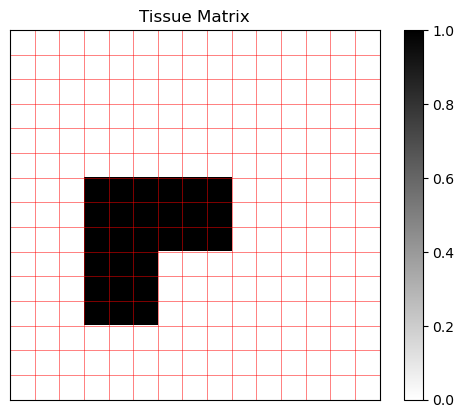

Optimization successful.
Optimal value: 5940.0
Optimal solution: [ 0.  0.  0.  0.  0.  0. 70. 70. 70. 30. 30. 30.  0.  0.  0.  0.  0.  0.
 70. 70. 70. 30. 30. 30.  0.  0.  0.  0.  0.  0.]


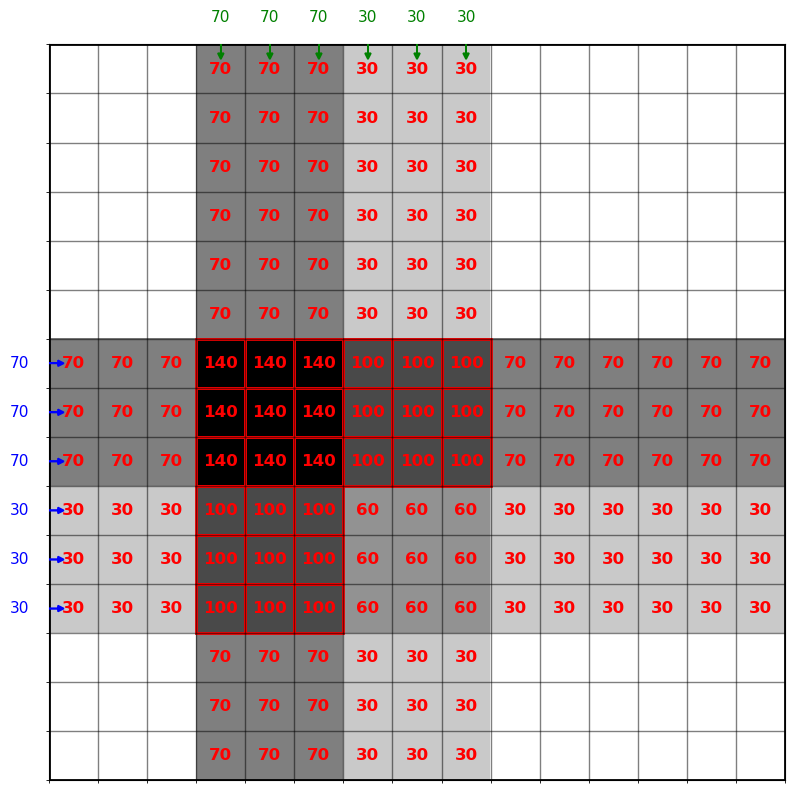

In [53]:
# test the class
tissue_matrix = np.array([[0, 0, 0, 0, 0],
                           [0, 0, 0, 0, 0],   
                           [0, 1, 1, 0, 0],
                           [0, 1, 0, 0, 0],
                           [0, 0, 0, 0, 0]])

# upscale
upscale_factor = 3
tissue_matrix = upscale_matrix(tissue_matrix, upscale_factor)

MaxDoseHealthyCells = 70
beam_type = 'constant'  # or 'exponential', 'simulated', etc.
lac = 1  # linear attenuation coefficient for exponential beam type
tissue_problem = TissueIrradiationProblem(tissue_matrix, min_dose_tumor=100, max_dose_healthy=MaxDoseHealthyCells,beam_type=beam_type, lac=lac)
tissue_problem.plot_tissue()
# exract the problem parameters
problem_parameters = {"nrows": tissue_problem.nrows,
                      "ncols": tissue_problem.ncols,
                      "tissue_matrix": tissue_problem.tissue_matrix,
                      "c_beams": tissue_problem.c_beams,
                      "A_ub": tissue_problem.A_ub,
                      "b_ub": tissue_problem.b_ub
                      }
tissue_optimizer = TissueIrradiationOptimizer(problem_parameters)
tissue_optimizer.optimize(doReport=True)

# plot irradiation scheme
tissue_optimizer.plot_irradiation_scheme()


---

Intermezzo:
 - the system seems to be much underdetermined
 - there are 4N beams = parameters
 - for them, only as many equations as there are tumor cells, unless we add aditional conditions
 - if N_tumor < 4N, --> underdetermined system
 -
 [[Was talking to ChatGPT and it pointed out this, so something big to consider]]

--------------
----------------


Final code?
---

In [189]:
class TissueIrradiationProblem:
    def __init__(self, tissue_matrix, min_dose_tumor=100, max_dose_healthy=None, beam_type='constant', lac=1.0):
        self.tissue_matrix = np.array(tissue_matrix)
        self.min_dose_tumor = min_dose_tumor
        self.max_dose_healthy = max_dose_healthy
        self.nrows, self.ncols = self.tissue_matrix.shape
        self.ncells = self.nrows * self.ncols
        self.lac = lac  # linear attenuation coefficient
        self._analyze_tissue()
        self._build_problem(beam_type=beam_type, lac=self.lac)
        # self.A_eq and self.b_eq are set in _build_problem depending on beam_type

    def plot_tissue(self):
        cmap = colors.LinearSegmentedColormap.from_list('custom_bw', ['white', 'black'])
        plt.imshow(self.tissue_matrix, cmap=cmap, interpolation='nearest', vmin=0, vmax=1)
        plt.colorbar()
        plt.title('Tissue Matrix')
        ax = plt.gca()
        ax.set_xticks(np.arange(-0.5, self.ncols, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, self.nrows, 1), minor=True)
        ax.grid(which='minor', color='red', linestyle='-', linewidth=0.7, alpha=0.5)
        ax.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
        plt.show()

    def _analyze_tissue(self):
        self.tumor_positions = np.argwhere(self.tissue_matrix == 1)
        self.healthy_positions = np.argwhere(self.tissue_matrix == 0)
        self.n_tumor = len(self.tumor_positions)
        self.n_healthy = len(self.healthy_positions)
        self.n_beams = 2 * (self.nrows + self.ncols)

    def _build_problem(self, beam_type='constant', lac=1.0):
        healthy_in_rows = np.sum(self.tissue_matrix == 0, axis=1)
        healthy_in_cols = np.sum(self.tissue_matrix == 0, axis=0)
        # Use float dtype to accommodate exponential values
        dtype = int if beam_type == 'constant' else float
        self.A_tissue = np.zeros((self.ncells, self.n_beams), dtype=dtype)
        self.A_tumor = []
        self.A_healthy = []

        if beam_type == 'constant':
            print("Using constant intensity beam model.")
            c_beams = np.concatenate([healthy_in_rows, healthy_in_rows, healthy_in_cols, healthy_in_cols])

            # Fill A_tissue, A_tumor, and A_healthy in a single loop
            for idx in range(self.ncells):
                i = idx // self.ncols
                j = idx % self.ncols
                row = np.zeros(self.n_beams, dtype=int)  # Use int for constant values
                row[i] = 1  # left beam
                row[self.nrows + i] = 1  # right beam
                row[2 * self.nrows + j] = 1  # top beam
                row[2 * self.nrows + self.ncols + j] = 1  # bottom beam
                self.A_tissue[idx] = row
                if self.tissue_matrix[i, j] == 1:
                    self.A_tumor.append(row)
                else:
                    self.A_healthy.append(row)
            self.A_tumor = np.array(self.A_tumor)
            self.A_healthy = np.array(self.A_healthy)
            

            # add A_eq for dead beams (set right and bottom beams to zero)
            dead_beams_matrix = np.zeros((self.nrows + self.ncols, self.n_beams), dtype=int)
            for i in range(self.nrows):
                dead_beams_matrix[i, self.nrows + i] = 1  # right beams
            for j in range(self.ncols):
                dead_beams_matrix[self.nrows + j, 2 * self.nrows + self.ncols + j] = 1  # bottom beams
            self.A_eq = dead_beams_matrix
            self.b_eq = np.zeros(self.nrows + self.ncols)

        elif beam_type == 'exponential':
            print("Using exponential intensity beam model with linear attenuation coefficient (lac):", lac)
            c_left = np.zeros(self.nrows)
            c_right = np.zeros(self.nrows)
            c_top = np.zeros(self.ncols)
            c_bottom = np.zeros(self.ncols)
            for i in range(self.nrows):
                js = self.healthy_positions[self.healthy_positions[:, 0] == i][:, 1]
                c_left[i] = np.sum(np.exp(-lac * js))
                c_right[i] = np.sum(np.exp(-lac * (self.ncols - js - 1)))
            for j in range(self.ncols):
                is_ = self.healthy_positions[self.healthy_positions[:, 1] == j][:, 0]
                c_top[j] = np.sum(np.exp(-lac * is_))
                c_bottom[j] = np.sum(np.exp(-lac * (self.nrows - is_ - 1)))
            c_beams = np.concatenate([c_left, c_right, c_top, c_bottom])

            # Fill A_tissue, A_tumor, and A_healthy in a single loop
            for idx in range(self.ncells):
                i = idx // self.ncols
                j = idx % self.ncols
                row = np.zeros(self.n_beams, dtype=float)  # Use float for exponential values
                row[i] = np.exp(-lac * j)
                row[self.nrows + i] = np.exp(-lac * (self.ncols - j - 1))
                row[2 * self.nrows + j] = np.exp(-lac * i)
                row[2 * self.nrows + self.ncols + j] = np.exp(-lac * (self.nrows - i - 1))
                self.A_tissue[idx] = row
                #print(f"\ni={i}, j={j}, row={row}")
                # i) this one works?
                # if [i, j] in self.tumor_positioens.tolist():
                #     self.A_tumor.append(row)
                # elif [i, j] in self.healthy_positions.tolist():
                #     self.A_healthy.append(row)
                # ii) definetly works
                if self.tissue_matrix[i, j] == 1:
                    self.A_tumor.append(row)
                else:
                    self.A_healthy.append(row)

            self.A_tumor = np.array(self.A_tumor)
            #print(f"A_tumor = {self.A_tumor}")
            #print(f"A_tissue = {self.A_tissue}")
            self.A_healthy = np.array(self.A_healthy)
            self.A_eq = None
            self.b_eq = None

        elif beam_type == 'simulated':
            print("Using beam from self simulated data for energy deposition distribution.")
            a = 2
            #A_tumor = np.zeros((self.n_tumor, self.n_beams), dtype=float)
            self.A_eq = None
            self.b_eq = None

        elif beam_type in ['proton', 'neutron', 'electron', 'other_stuff']:
            raise NotImplementedError(f"Beam type '{beam_type}' is not implemented yet.")
        else:
            raise ValueError(f"Unknown beam type: {beam_type}")


        # make c_beams and A_ub attributes
        self.c_beams = c_beams

        # A_upper_bound - calculate from A_tumor and A_healthy - if max_dose_healthy is defined
        self.A_ub = -np.array(self.A_tumor)  # MINUS!!!
        if self.max_dose_healthy is not None:
            self.A_ub = np.vstack((self.A_ub, self.A_healthy))

        #self.A_tumor = A_tumor
        #self.A_healthy = A_healthy
        #self.A_ub = A_ub
        
        # add b_ub - same for all beam types
        self.b_ub = -np.ones(self.n_tumor) * self.min_dose_tumor  # MINUS!!!
        if self.max_dose_healthy is not None:
            self.b_ub = np.concatenate((self.b_ub, np.ones(self.n_healthy) * self.max_dose_healthy))


class TissueIrradiationOptimizer:
    def __init__(self, problem_parameters):
        self.problem_parameters = problem_parameters
        self.optimized = False

        # extract parameters from problem_parameters
        self.nrows = problem_parameters["nrows"]
        self.ncols = problem_parameters["ncols"]
        self.ncells = self.nrows * self.ncols
        self.nbeams = 2 * (self.nrows + self.ncols)
        self.tissue_matrix = problem_parameters["tissue_matrix"]
        self.c_beams = problem_parameters["c_beams"]
        self.A_tissue = problem_parameters.get("A_tissue", None)
        self.A_tumor = problem_parameters.get("A_tumor", None)
        self.A_healthy = problem_parameters.get("A_healthy", None)
        self.A_ub = problem_parameters["A_ub"]
        self.b_ub = problem_parameters["b_ub"]
        self.A_eq = problem_parameters.get("A_eq", None)
        self.b_eq = problem_parameters.get("b_eq", None)

        #self.optimal_beam_intensities = None
        self.optimal_beam_intensities = np.zeros(self.nbeams)  # Initialize with zeros
        self.DH_tot = -99
        self.optimized = False

    def optimize(self, doReport=False):        
        result = linprog(c=self.c_beams, A_ub=self.A_ub, b_ub=self.b_ub, method='highs',A_eq=self.A_eq, b_eq=self.b_eq)
        self.result = result
        
        if result.success:
            self.optimal_beam_intensities = result.x
            self.DH_tot = result.fun
            self.optimized = True
            if doReport:
                print("Optimization successful.")
                print("Optimal value:", result.fun)
                print("Optimal solution:", result.x)
                # Calculate dose distribution
                self.calculate_dose_distribution()
        else:
            print("Optimization failed:", result.message)
            # self.optimal_beam_intensities = None
            # self.DH_tot = None
            # self.optimized = False

    def calculate_dose_distribution(self):
        if not self.optimized:
            print("Run optimize() first.")
            return

        dose_matrix = np.zeros_like(self.tissue_matrix, dtype=float)
        for i in range(self.nrows):
            for j in range(self.ncols):
                dose_left = self.optimal_beam_intensities[i]
                dose_right = self.optimal_beam_intensities[self.nrows + i]
                dose_top = self.optimal_beam_intensities[2 * self.nrows + j]
                dose_bottom = self.optimal_beam_intensities[2 * self.nrows + self.ncols + j]
                dose_matrix[i, j] = dose_left + dose_right + dose_top + dose_bottom
        self.tissue_dose_matrix = dose_matrix
        # update
        self.tissue_dose_matrix_corrected = self.A_tissue @ self.optimal_beam_intensities.reshape(-1, 1)
        self.tissue_dose_matrix_corrected = self.tissue_dose_matrix_corrected.reshape(self.nrows, self.ncols)
        self.tissue_dose_matrix = self.tissue_dose_matrix_corrected

    def plot_dose_distribution(self):
        if not self.optimized:
            print("Run optimize() first.")
            return

        fig, ax = plt.subplots(figsize=(8, 8))
        cmap = colors.LinearSegmentedColormap.from_list('custom_bw', ['white', 'black'])
        im = ax.imshow(self.tissue_dose_matrix, cmap=cmap, interpolation='nearest', 
                       vmin=np.min(self.tissue_dose_matrix), vmax=np.max(self.tissue_dose_matrix),
                       extent=[-0.5, self.ncols-0.5, self.nrows-0.5, -0.5])

        # Draw grid lines for cells (only at cell boundaries)
        ax.set_xticks(np.arange(-0.5, self.ncols, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, self.nrows, 1), minor=True)
        ax.grid(which='minor', color='black', linestyle='-', linewidth=1, alpha=0.5)
        ax.set_xlim(-0.5, self.ncols-0.5)
        ax.set_ylim(self.nrows-0.5, -0.5)

        # Annotate each cell with its dose (if nonzero)
        for i in range(self.nrows):
            for j in range(self.ncols):
                dose = self.tissue_dose_matrix[i, j]
                if dose > 0:
                    ax.text(j, i, f"{dose:.0f}", ha='center', va='center', color='red', fontsize=12, fontweight='bold')

        # Highlight tumor cells with red edges
        tumor_mask = (self.tissue_matrix == 1)
        for (i, j) in np.argwhere(tumor_mask):
            rect = plt.Rectangle((j-0.5, i-0.5), 1, 1, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)

        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
        plt.show()

    def plot_irradiation_scheme(self):
        if not self.optimized:
            print("Run optimize() first.")
            return

        fig, ax = plt.subplots(figsize=(8, 8))
        cmap = colors.LinearSegmentedColormap.from_list('custom_bw', ['white', 'black'])
        im = ax.imshow(self.tissue_dose_matrix, cmap=cmap, interpolation='nearest', 
                       vmin=np.min(self.tissue_dose_matrix), vmax=np.max(self.tissue_dose_matrix),
                       extent=[-0.5, self.ncols-0.5, self.nrows-0.5, -0.5])

        # Draw grid lines for cells (only at cell boundaries)
        ax.set_xticks(np.arange(-0.5, self.ncols, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, self.nrows, 1), minor=True)
        ax.grid(which='minor', color='black', linestyle='-', linewidth=1, alpha=0.5)
        ax.set_xlim(-0.5, self.ncols-0.5)
        ax.set_ylim(self.nrows-0.5, -0.5)

        # Annotate each cell with its dose (if nonzero)
        for i in range(self.nrows):
            for j in range(self.ncols):
                dose = self.tissue_dose_matrix[i, j]
                if dose > 0:
                    ax.text(j, i, f"{dose:.0f}", ha='center', va='center', color='red', fontsize=12, fontweight='bold')

        # Highlight tumor cells with red edges
        tumor_mask = (self.tissue_matrix == 1)
        for (i, j) in np.argwhere(tumor_mask):
            rect = plt.Rectangle((j-0.5, i-0.5), 1, 1, linewidth=4, edgecolor='darkred', facecolor='none')
            ax.add_patch(rect)

        # Highlight tissue edges
        ax.plot([-0.5, self.ncols-0.5], [-0.5, -0.5], color='black', linewidth=2)
        ax.plot([-0.5, self.ncols-0.5], [self.nrows-0.5, self.nrows-0.5], color='black', linewidth=2)
        ax.plot([-0.5, -0.5], [-0.5, self.nrows-0.5], color='black', linewidth=2)
        ax.plot([self.ncols-0.5, self.ncols-0.5], [-0.5, self.nrows-0.5], color='black', linewidth=2)
        
        # Draw beams: horizontal (rows) and vertical (cols) with smaller arrows at the edges
        arrow_length = 0.7
        arrow_head_width = 0.12
        arrow_head_length = 0.12
        ## beam intensities from left and right directions
        for beam_idx in range(self.nrows):
            intensity_left = self.optimal_beam_intensities[beam_idx]
            intensity_right = self.optimal_beam_intensities[self.nrows + beam_idx]
            if intensity_left > 0:
                # Left edge arrow for row beams
                ax.arrow(-0.9, beam_idx, arrow_length, 0, head_width=arrow_head_width, head_length=arrow_head_length,
                         fc='blue', ec='blue', linewidth=1.2, length_includes_head=True, zorder=10)
                ax.text(-0.9, beam_idx, f"{intensity_left:.0f}", va='center', ha='right', color='blue', fontsize=11)
            if intensity_right > 0:
                # Right edge arrow for row beams
                ax.arrow(self.ncols-0.2, beam_idx, -arrow_length, 0, head_width=arrow_head_width, head_length=arrow_head_length,
                         fc='blue', ec='blue', linewidth=1.2, length_includes_head=True, zorder=10)
                ax.text(self.ncols-0.3, beam_idx, f"{intensity_right:.0f}", va='center', ha='left', color='blue', fontsize=11)
        
        # intensities from top and bottom directions
        for beam_idx in range(self.ncols):
            intensity_top = self.optimal_beam_intensities[2*self.nrows + beam_idx]
            intensity_bottom = self.optimal_beam_intensities[2*self.nrows + self.ncols + beam_idx]
            if intensity_top > 0:
                # Top edge arrow for column beams
                ax.arrow(beam_idx, -0.9, 0, arrow_length, head_width=arrow_head_width, head_length=arrow_head_length,
                         fc='green', ec='green', linewidth=1.2, length_includes_head=True, zorder=10)
                ax.text(beam_idx, -0.7, f"{intensity_top:.0f}", va='bottom', ha='center', color='green', fontsize=11)
            if intensity_bottom > 0:
                # Bottom edge arrow for column beams
                ax.arrow(beam_idx, self.nrows-0.3, 0, arrow_length, head_width=arrow_head_width, head_length=arrow_head_length,
                         fc='green', ec='green', linewidth=1.2, length_includes_head=True, zorder=10)
                ax.text(beam_idx, self.nrows-0.3, f"{intensity_bottom:.0f}", va='top', ha='center', color='green', fontsize=11)

        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
        plt.show()

    def report_statistics(self):
        print("Statistics:")
        if not hasattr(self, 'tissue_dose_matrix'): 
            print("Run calculate_dose_distribution() first.")
            return  
        tumor_mask = (self.tissue_matrix == 1)
        healthy_mask = (self.tissue_matrix == 0)
        avg_dose_tumor = self.tissue_dose_matrix[tumor_mask].mean() if np.any(tumor_mask) else 0
        avg_dose_healthy = self.tissue_dose_matrix[healthy_mask].mean() if np.any(healthy_mask) else 0
        print(f"Average dose to tumor cells: {avg_dose_tumor:.2f}")
        print(f"Average dose to healthy cells: {avg_dose_healthy:.2f}")




In [74]:
# import npy file from the folder
SIF_expanded = np.load('SIF_expanded.npy')
### SIF = Simulation Irradioation Factors

In [ ]:
class TissueIrradiationProblem:
    def __init__(self, tissue_matrix): 
    ############  thing to consider - attribute initalisation point ##############
    #, min_dose_tumor=100,...): - decided to define stuff in prepare_data_for_linprog method - smart or not??
    
        self.tissue_matrix = np.array(tissue_matrix)
        self.nrows, self.ncols = self.tissue_matrix.shape
        self.ncells = self.nrows * self.ncols
        self._analyze_tissue()
        
    def plot_tissue(self):
        cmap = colors.LinearSegmentedColormap.from_list('custom_bw', ['white', 'black'])
        plt.imshow(self.tissue_matrix, cmap=cmap, interpolation='nearest', vmin=0, vmax=1)
        plt.colorbar()
        plt.title('Tissue Matrix')
        ax = plt.gca()
        ax.set_xticks(np.arange(-0.5, self.ncols, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, self.nrows, 1), minor=True)
        ax.grid(which='minor', color='red', linestyle='-', linewidth=0.7, alpha=0.5)
        ax.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
        plt.show()

    def _analyze_tissue(self):
        self.tumor_positions = np.argwhere(self.tissue_matrix == 1)
        self.healthy_positions = np.argwhere(self.tissue_matrix == 0)
        self.n_tumor = len(self.tumor_positions)
        self.n_healthy = len(self.healthy_positions)
        self.n_beams = 2 * (self.nrows + self.ncols)

    def prepare_data_for_linprog(self,cell_dose_constr,beam_type='constant', lac=1.0,sim_irr_factors=None):
        """
        Prepare the data for linear programming optimization.
        This method creates the necessary matrices and vectors for the optimization problem.
        """
        self.beam_type = beam_type
        self.lac = lac
        self.simulation_irradiation_factors = sim_irr_factors
        self.cell_dose_constr = cell_dose_constr  
        self.min_dose_tumor = cell_dose_constr['min_dose_tumor']
        self.max_dose_healthy = cell_dose_constr.get('max_dose_healthy', None) # this one is optional
        # run methods to prepare data for linear programming
        self.create_dose_distribution_matrix()
        self.define_linprog_inputs()
        self.define_linprog_inputs()

        return {
            "c": self.c_beams,
            "A_ub": self.A_ub,
            "b_ub": self.b_ub,
            "A_eq": self.A_eq,
            "b_eq": self.b_eq,
            # "tissue_matrix": self.tissue_matrix,
            # "nrows": self.nrows,
            # "ncols": self.ncols,
            # "n_beams": self.n_beams,
            # "delta_kij": self.delta_kij,
            # "beam_type": self.beam_type,
            # "lac": self.lac,
            # "simulation_irradiation_factors": self.simulation_irradiation_factors,
            # "min_dose_tumor": self.min_dose_tumor,
            # "max_dose_healthy": self.max_dose_healthy,
        }

    def create_dose_distribution_matrix(self):
        """
        Create the 3D dose distribution matrix (delta_kij) for the tissue matrix.
        Uses N_rows and N_cols from the notebook variables if available.
        Returns a numpy array of shape (N_beams, N_rows, N_cols).
        """
        # Use N_rows and N_cols from notebook if available, else from self
        nrows = self.nrows
        ncols = self.ncols
        n_beams = self.n_beams
        delta_kij = np.zeros((n_beams, nrows, ncols), dtype=float)

        # Fill delta_kij for all beams in a single loop, separating beam_type only once
        if self.beam_type == 'constant':
            print("Using constant intensity beam model.")
            # Left beams (rows)
            for i in range(nrows):
                for j in range(ncols):
                    delta_kij[i, i, j] = 1.0
            # Right beams (rows)
            for i in range(nrows):
                for j in range(ncols):
                    delta_kij[nrows + i, i, j] = 1.0
            # Top beams (cols)
            for j in range(ncols):
                for i in range(nrows):
                    delta_kij[2 * nrows + j, i, j] = 1.0
            # Bottom beams (cols)
            for j in range(ncols):
                for i in range(nrows):
                    delta_kij[2 * nrows + ncols + j, i, j] = 1.0
        elif self.beam_type == 'exponential':
            print("Using exponential intensity beam model with linear attenuation coefficient (lac):", lac, "/cm")
            lac = self.lac
            # Left beams (rows)
            for i in range(nrows):
                for j in range(ncols):
                    delta_kij[i, i, j] = np.exp(-lac * j)
            # Right beams (rows)
            for i in range(nrows):
                for j in range(ncols):
                    delta_kij[nrows + i, i, j] = np.exp(-lac * (ncols - j - 1))
            # Top beams (cols)
            for j in range(ncols):
                for i in range(nrows):
                    delta_kij[2 * nrows + j, i, j] = np.exp(-lac * i)
            # Bottom beams (cols)
            for j in range(ncols):
                for i in range(nrows):
                    delta_kij[2 * nrows + ncols + j, i, j] = np.exp(-lac * (nrows - i - 1))
        
        elif self.beam_type == 'simulated':
            print("Using beam from self simulated data for energy deposition distribution.")
            # Simulated beams logic would go here, similar to the above but using simulated data
            # For now, we will just fill with zeros as a placeholder
            if self.simulation_irradiation_factors is None:
                raise ValueError("Simulation_irradiation_factors must be provided for 'simulated' beam type.")
            delta_kij = self.simulation_irradiation_factors

        elif beam_type in ['proton', 'neutron', 'electron', 'other_stuff']:
            raise NotImplementedError(f"Beam type '{beam_type}' is not implemented yet.")
        else:
            raise ValueError(f"Unknown beam_type: {beam_type}")
        
        # at the end, make delta_kij factors matrix an attribute
        self.delta_kij = delta_kij

    def define_linprog_inputs(self):
        self.c_beams = np.zeros(self.n_beams, dtype=float)
        self.A_tissue = np.zeros((self.ncells, self.n_beams))
        self.A_tumor = []
        self.A_healthy = []
        self.A_eq = None
        self.b_eq = None

        # define c_beams
        for i in range(self.n_beams):
            self.c_beams[i] = np.sum(self.delta_kij[i, self.tissue_matrix == 0])  # Sum over healthy cells for constant beam
        # define A_tissue
        for idx in range(self.ncells):
            i = idx // self.ncols
            j = idx % self.ncols
            row = np.zeros(self.n_beams, dtype=float)
            for k in range(self.n_beams):
                row[k] = self.delta_kij[k, i, j]
            self.A_tissue[idx] = row
            if self.tissue_matrix[i, j] == 1:
                self.A_tumor.append(row)
            else:
                self.A_healthy.append(row)
        # define A_eq and b_eq if constant beam type - because we cancel beams from the right and bottom
        if self.beam_type == 'constant':
            # add A_eq for dead beams (set right and bottom beams to zero)
            dead_beams_matrix = np.zeros((self.nrows + self.ncols, self.n_beams), dtype=int)
            for i in range(self.nrows):
                dead_beams_matrix[i, self.nrows + i] = 1  # right beams
            for j in range(self.ncols):
                dead_beams_matrix[self.nrows + j, 2 * self.nrows + self.ncols + j] = 1  # bottom beams
            self.A_eq = dead_beams_matrix
            self.b_eq = np.zeros(self.nrows + self.ncols)

        self.A_tumor = np.array(self.A_tumor)
        self.A_healthy = np.array(self.A_healthy)
        # define A_upper_bound - just A_tumor and b_ub, but both with minus as we minimize!
        self.A_ub = -np.array(self.A_tumor)  # MINUS!!!
        self.b_ub = -np.ones(self.n_tumor) * self.min_dose_tumor  # MINUS!!!
        # add A_healthy and extend b_ub if max dose to H cells is prescribed
        if self.max_dose_healthy is not None:
            self.A_ub = np.vstack((self.A_ub, self.A_healthy))
            self.b_ub = np.concatenate((self.b_ub, np.ones(self.n_healthy) * self.max_dose_healthy))
            


In [ ]:
class TissueIrradiationOptimizer:
    def __init__(self, problem_parameters):
        self.problem_parameters = problem_parameters
        self.optimized = False

        # extract parameters from problem_parameters
        self.nrows = problem_parameters["nrows"]
        self.ncols = problem_parameters["ncols"]
        self.ncells = self.nrows * self.ncols
        self.nbeams = 2 * (self.nrows + self.ncols)
        self.tissue_matrix = problem_parameters["tissue_matrix"]
        self.c_beams = problem_parameters["c_beams"]
        self.A_tissue = problem_parameters.get("A_tissue", None)
        self.A_tumor = problem_parameters.get("A_tumor", None)
        self.A_healthy = problem_parameters.get("A_healthy", None)
        self.A_ub = problem_parameters["A_ub"]
        self.b_ub = problem_parameters["b_ub"]
        self.A_eq = problem_parameters.get("A_eq", None)
        self.b_eq = problem_parameters.get("b_eq", None)

        #self.optimal_beam_intensities = None
        self.optimal_beam_intensities = np.zeros(self.nbeams)  # Initialize with zeros
        self.DH_tot = -99
        self.optimized = False

    def optimize(self, doReport=False):        
        result = linprog(c=self.c_beams, A_ub=self.A_ub, b_ub=self.b_ub, method='highs',A_eq=self.A_eq, b_eq=self.b_eq)
        self.result = result
        
        if result.success:
            self.optimal_beam_intensities = result.x
            self.DH_tot = result.fun
            self.optimized = True
            if doReport:
                print("Optimization successful.")
                print("Optimal value:", result.fun)
                print("Optimal solution:", result.x)
                # Calculate dose distribution
                self.calculate_dose_distribution()
        else:
            print("Optimization failed:", result.message)
            # self.optimal_beam_intensities = None
            # self.DH_tot = None
            # self.optimized = False

    def calculate_dose_distribution(self):
        if not self.optimized:
            print("Run optimize() first.")
            return
        self.tissue_dose_matrix = self.A_tissue @ self.optimal_beam_intensities.reshape(-1, 1) # reshape: make a column out of line
        self.tissue_dose_matrix = self.tissue_dose_matrix.reshape(self.nrows, self.ncols) # reshape to tissue matrix shape

    def plot_dose_distribution(self):
        if not self.optimized:
            print("Run optimize() first.")
            return

        fig, ax = plt.subplots(figsize=(8, 8))
        cmap = colors.LinearSegmentedColormap.from_list('custom_bw', ['white', 'black'])
        im = ax.imshow(self.tissue_dose_matrix, cmap=cmap, interpolation='nearest', 
                       vmin=np.min(self.tissue_dose_matrix), vmax=np.max(self.tissue_dose_matrix),
                       extent=[-0.5, self.ncols-0.5, self.nrows-0.5, -0.5])

        # Draw grid lines for cells (only at cell boundaries)
        ax.set_xticks(np.arange(-0.5, self.ncols, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, self.nrows, 1), minor=True)
        ax.grid(which='minor', color='black', linestyle='-', linewidth=1, alpha=0.5)
        ax.set_xlim(-0.5, self.ncols-0.5)
        ax.set_ylim(self.nrows-0.5, -0.5)

        # Annotate each cell with its dose (if nonzero)
        for i in range(self.nrows):
            for j in range(self.ncols):
                dose = self.tissue_dose_matrix[i, j]
                if dose > 0:
                    ax.text(j, i, f"{dose:.0f}", ha='center', va='center', color='red', fontsize=12, fontweight='bold')

        # Highlight tumor cells with red edges
        tumor_mask = (self.tissue_matrix == 1)
        for (i, j) in np.argwhere(tumor_mask):
            rect = plt.Rectangle((j-0.5, i-0.5), 1, 1, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)

        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
        plt.show()

    def plot_irradiation_scheme(self):
        if not self.optimized:
            print("Run optimize() first.")
            return

        fig, ax = plt.subplots(figsize=(8, 8))
        cmap = colors.LinearSegmentedColormap.from_list('custom_bw', ['white', 'black'])
        im = ax.imshow(self.tissue_dose_matrix, cmap=cmap, interpolation='nearest', 
                       vmin=np.min(self.tissue_dose_matrix), vmax=np.max(self.tissue_dose_matrix),
                       extent=[-0.5, self.ncols-0.5, self.nrows-0.5, -0.5])

        # Draw grid lines for cells (only at cell boundaries)
        ax.set_xticks(np.arange(-0.5, self.ncols, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, self.nrows, 1), minor=True)
        ax.grid(which='minor', color='black', linestyle='-', linewidth=1, alpha=0.5)
        ax.set_xlim(-0.5, self.ncols-0.5)
        ax.set_ylim(self.nrows-0.5, -0.5)

        # Annotate each cell with its dose (if nonzero)
        for i in range(self.nrows):
            for j in range(self.ncols):
                dose = self.tissue_dose_matrix[i, j]
                if dose > 0:
                    ax.text(j, i, f"{dose:.0f}", ha='center', va='center', color='red', fontsize=12, fontweight='bold')

        # Highlight tumor cells with red edges
        tumor_mask = (self.tissue_matrix == 1)
        for (i, j) in np.argwhere(tumor_mask):
            rect = plt.Rectangle((j-0.5, i-0.5), 1, 1, linewidth=4, edgecolor='darkred', facecolor='none')
            ax.add_patch(rect)

        # Highlight tissue edges
        ax.plot([-0.5, self.ncols-0.5], [-0.5, -0.5], color='black', linewidth=2)
        ax.plot([-0.5, self.ncols-0.5], [self.nrows-0.5, self.nrows-0.5], color='black', linewidth=2)
        ax.plot([-0.5, -0.5], [-0.5, self.nrows-0.5], color='black', linewidth=2)
        ax.plot([self.ncols-0.5, self.ncols-0.5], [-0.5, self.nrows-0.5], color='black', linewidth=2)
        
        # Draw beams: horizontal (rows) and vertical (cols) with smaller arrows at the edges
        arrow_length = 0.7
        arrow_head_width = 0.12
        arrow_head_length = 0.12
        ## beam intensities from left and right directions
        for beam_idx in range(self.nrows):
            intensity_left = self.optimal_beam_intensities[beam_idx]
            intensity_right = self.optimal_beam_intensities[self.nrows + beam_idx]
            if intensity_left > 0:
                # Left edge arrow for row beams
                ax.arrow(-0.9, beam_idx, arrow_length, 0, head_width=arrow_head_width, head_length=arrow_head_length,
                         fc='blue', ec='blue', linewidth=1.2, length_includes_head=True, zorder=10)
                ax.text(-0.9, beam_idx, f"{intensity_left:.0f}", va='center', ha='right', color='blue', fontsize=11)
            if intensity_right > 0:
                # Right edge arrow for row beams
                ax.arrow(self.ncols-0.2, beam_idx, -arrow_length, 0, head_width=arrow_head_width, head_length=arrow_head_length,
                         fc='blue', ec='blue', linewidth=1.2, length_includes_head=True, zorder=10)
                ax.text(self.ncols-0.3, beam_idx, f"{intensity_right:.0f}", va='center', ha='left', color='blue', fontsize=11)
        
        # intensities from top and bottom directions
        for beam_idx in range(self.ncols):
            intensity_top = self.optimal_beam_intensities[2*self.nrows + beam_idx]
            intensity_bottom = self.optimal_beam_intensities[2*self.nrows + self.ncols + beam_idx]
            if intensity_top > 0:
                # Top edge arrow for column beams
                ax.arrow(beam_idx, -0.9, 0, arrow_length, head_width=arrow_head_width, head_length=arrow_head_length,
                         fc='green', ec='green', linewidth=1.2, length_includes_head=True, zorder=10)
                ax.text(beam_idx, -0.7, f"{intensity_top:.0f}", va='bottom', ha='center', color='green', fontsize=11)
            if intensity_bottom > 0:
                # Bottom edge arrow for column beams
                ax.arrow(beam_idx, self.nrows-0.3, 0, arrow_length, head_width=arrow_head_width, head_length=arrow_head_length,
                         fc='green', ec='green', linewidth=1.2, length_includes_head=True, zorder=10)
                ax.text(beam_idx, self.nrows-0.3, f"{intensity_bottom:.0f}", va='top', ha='center', color='green', fontsize=11)

        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
        plt.show()

    def report_statistics(self):
        print("Statistics:")
        if not hasattr(self, 'tissue_dose_matrix'): 
            print("Run calculate_dose_distribution() first.")
            return  
        tumor_mask = (self.tissue_matrix == 1)
        healthy_mask = (self.tissue_matrix == 0)
        avg_dose_tumor = self.tissue_dose_matrix[tumor_mask].mean() if np.any(tumor_mask) else 0
        avg_dose_healthy = self.tissue_dose_matrix[healthy_mask].mean() if np.any(healthy_mask) else 0
        print(f"Average dose to tumor cells: {avg_dose_tumor:.2f}")
        print(f"Average dose to healthy cells: {avg_dose_healthy:.2f}")


learning how ...

In [1]:
I = np.array([0,1,2,1])
print(np.shape(I))
print(np.shape(I.reshape(-1, 1)))
#I = I.reshape(-1,1)

A = np.array([[1,2,1,0],
              [0,1,2,2],
              [0,0,1,1]])
            #[1,0,0,0]])
print(np.shape(A))  ## turns out shape is (3, 4) - 3 rows, 4 columns
#### importnat consequence, vector shall be Nx1, but eg I, defined few lines above, has a shape if 1XN (N=4) - not reallya vector!
A = np.array([1,2,0,1]) #.reshape(-1, 1)

res = A @ I.reshape(-1, 1)
print(f"res = {res}, (shape = {np.shape(res)})")
#res.reshape(1,1)

# next example, 2X1 matrix
N_rows = 2
N_cols = 1
I = np.array([1,1,3,0,2,1])
A = np.array([[1, 0, 1, 0, 1, 1],
              [0, 2, 0, 2, 1, 1]])

I = I.reshape(-1, 1)  # Reshape to a column vector
res = A @ I
# reshape result
res = res.reshape(N_rows, N_cols)  # Reshape to a column vector
print(f"\nResult for irradinating tissue of shape: {N_rows}x{N_cols} with {len(I)} beams:\n{res}\n")


NameError: name 'np' is not defined

3d arrays

In [47]:
"""
Working with 3D arrays in numpy
"""

# Create 5 matrices of shape 2x3
matrices = [np.random.randint(0, 10, (2, 3)) for _ in range(5)]

# Stack them into a 3D array: shape will be (5, 2, 3)
delta_kij = np.stack(matrices, axis=0)

print("-------------Working with 3D arrays in numpy--------------")
print("Shape of delta_kij matrix:", delta_kij.shape)
print("3D array:\n", delta_kij)

# Accessing the 3rd matrix (index 2)
print("\n\nMatrix 3:\n", delta_kij[2])

# extract last matirx from data
LastMatrix = delta_kij[-1]
print("\nLast Matrix:\n", LastMatrix)
print(f"Shape of matrix: {LastMatrix.shape}")

LastMatrix[0] # first row
print(f"First row: {LastMatrix[0]}")
LastMatrix[:,-1] # last column
print(f"Last column: {LastMatrix[:,-1]}")

-------------Working with 3D arrays in numpy--------------
Shape of delta_kij matrix: (5, 2, 3)
3D array:
 [[[1 1 8]
  [7 1 8]]

 [[8 8 7]
  [0 7 7]]

 [[9 6 1]
  [8 5 5]]

 [[4 9 9]
  [0 3 1]]

 [[2 7 2]
  [5 1 1]]]


Matrix 3:
 [[9 6 1]
 [8 5 5]]

Last Matrix:
 [[2 7 2]
 [5 1 1]]
Shape of matrix: (2, 3)
First row: [2 7 2]
Last column: [2 1]


building beam matrix - delta_kij

In [ ]:
def build_beam_matrix_3d(N_rows, N_cols, beam='constant', lac=1.0):
    """
    Returns a 3D matrix of shape (Nb, N_rows, N_cols) for the specified beam type.
    - beam: 'constant' or 'exponential'
    - lac: linear attenuation coefficient (used only for 'exponential')
    """
    Nb = 2 * N_rows + 2 * N_cols
    matrix_3d = np.zeros((Nb, N_rows, N_cols), dtype=float)
    for i in range(N_rows):
        for j in range(N_cols):
            if beam == 'constant':
                # left beam
                matrix_3d[i, i, j] = 1
                # right beam
                matrix_3d[N_rows + i, i, j] = 1
                # top beam
                matrix_3d[2 * N_rows + j, i, j] = 1
                # bottom beam
                matrix_3d[2 * N_rows + N_cols + j, i, j] = 1
            elif beam == 'exponential':
                # left beam
                matrix_3d[i, i, j] = np.exp(-lac * j)
                # right beam
                matrix_3d[N_rows + i, i, j] = np.exp(-lac * (N_cols - j - 1))
                # top beam
                matrix_3d[2 * N_rows + j, i, j] = np.exp(-lac * i)
                # bottom beam
                matrix_3d[2 * N_rows + N_cols + j, i, j] = np.exp(-lac * (N_rows - i - 1))
            else:
                raise ValueError("beam must be 'constant' or 'exponential'")
    return matrix_3d

# Example usage:
# matrix_3d_const = build_beam_matrix_3d(N_rows, N_cols, beam='constant')
# matrix_3d_exp = build_beam_matrix_3d(N_rows, N_cols, beam='exponential', lac=0.7)



figuring out how to calculate dose to cells from I and A_tissue

In [38]:
# plotting time
tissue_optimizer.plot_dose_distribution()
tissue_optimizer.plot_irradiation_scheme()
# report statistics
tissue_optimizer.report_statistics()

(4,)
(4, 1)
(3, 4)
res = [3], (shape = (1,))

Result for irradinating tissue of shape: 2x1 with 6 beams:
[[7]
 [5]]



In [ ]:
def Dose_ij(i,j,lam,J_vec):
    """ 
    i,j are indices of the cell in the tissue matrix,
    lam is the linear attenuation coefficient,
    J_vec is the vector of beam intensities (J0) for each beam. (beams are pencil-like and attenuated, there are
    now beams from left, right, above and under the tissue matrix, so we have 
    2*Nrows + 2*Ncols beams, where Nrows and Ncols are the number of rows and columns in the tissue matrix)
    """
    J_left = np.exp(-lam*j) * J_vec[i] # beam from the left
    J_right = np.exp(-lam*(Ncols - j - 1)) * J_vec[Nrows + i] # beam from the right
    J_above = np.exp(-lam*i) * J_vec[2*Nrows + j] # beam from above
    J_under = np.exp(-lam*(Nrows - i - 1)) * J_vec[2*Nrows + Ncols + j] # beam from under
    
    return J_left + J_right + J_above + J_under
    


: 

In [ ]:
""" 
Defining Aub for the linear programming problem.
Aub will represent the constraints for the linear programming problem.  
Each tumor cell must receive at least MinDoseTumorCells units of radiation,
and - additionally but not necessary -  healthy cells must not receive more than MaxDoseHealthyCells units of radiation. 
"""

# example for cell with index [i,j] in the tissue matrix
# first we count the number of tumor cells in the tissue matrix
TumorBeamMatrix = countcells["TumorBeamMatrix"]
# now we can define Aub shape - fill it with zeros
# number of rows is equal to the number of tumor cells, number of columns is equal to 2*Nrows + 2*Ncols
Nrows, Ncols = TissueMatrix.shape
NumberOfTumorCells = TumorBeamMatrix.shape[0]
print("Number of rows in TissueMatrix:", Nrows)
print("Number of columns in TissueMatrix:", Ncols)  
print("Number of tumor cells:", NumberOfTumorCells)
Aub = np.zeros((NumberOfTumorCells, 2*Nrows + 2*Ncols), dtype=float)
# fill Aub with the contributions of each beam to the dose received by each tumor cell
for idx, (i, j) in enumerate(TumorPositions):
    Aub[idx, i] = np.exp(-lam * j)  # contribution from the left beam
    Aub[idx, Nrows + i] = np.exp(-lam * (Ncols - j - 1))  # contribution from the right beam
    Aub[idx, 2*Nrows + j] = np.exp(-lam * i)  # contribution from the above beam
    Aub[idx, 2*Nrows + Ncols + j] = np.exp(-lam * (Nrows - i - 1))  # contribution from the under beam
# print Aub shape and first row
print("Aub shape:", Aub.shape)
print("Aub first row:", Aub[0])

# define bub for the linear programming problem
MinDoseTumorCells = 100
bub = np.ones(NumberOfTumorCells) * MinDoseTumorCells
# print bub shape and first value
print("bub shape:", bub.shape)
print("bub first value:", bub[0])


Number of rows in TissueMatrix: 4
Number of columns in TissueMatrix: 3
Number of tumor cells: 4
Aub shape: (4, 14)
Aub first row: [1.         0.         0.         0.         0.13533528 0.
 0.         0.         1.         0.         0.         0.04978707
 0.         0.        ]
bub shape: (4,)
bub first value: 100.0


In [ ]:
# Now we can define Aub for healthy cells
HealthyBeamMatrix = countcells["HealthyBeamMatrix"]
# number of healthy cells
NumberOfHealthyCells = HealthyBeamMatrix.shape[0]
# define Aub shape - fill it with zeros
Aub_healthy = np.zeros((NumberOfHealthyCells, 2*Nrows + 2*Ncols), dtype=float)
# fill Aub_healthy with the contributions of each beam to the dose received by each healthy cell
for idx, (i, j) in enumerate(HealthyPositions):
    Aub_healthy[idx, i] = np.exp(-lam * j)  # contribution from the left beam
    Aub_healthy[idx, Nrows + i] = np.exp(-lam * (Ncols - j - 1))  # contribution from the right beam
    Aub_healthy[idx, 2*Nrows + j] = np.exp(-lam * i)  # contribution from the above beam
    Aub_healthy[idx, 2*Nrows + Ncols + j] = np.exp(-lam * (Nrows - i - 1))  # contribution from the under beam
# print Aub_healthy shape and first row
print("Aub_healthy shape:", Aub_healthy.shape)
print("Aub_healthy first row:", Aub_healthy[0])
# define bub_healthy for the linear programming problem
MaxDoseHealthyCells = 70
bub_healthy = np.ones(NumberOfHealthyCells) * MaxDoseHealthyCells
# print bub_healthy shape and first value
print("bub_healthy shape:", bub_healthy.shape)
print("bub_healthy first value:", bub_healthy[0])

# Now we can combine Aub and bub for the linear programming problem
Aub = np.vstack((Aub, Aub_healthy))
bub = np.concatenate((bub, bub_healthy))


Aub_healthy shape: (8, 14)
Aub_healthy first row: [0.36787944 0.         0.         0.         0.36787944 0.
 0.         0.         0.         1.         0.         0.
 0.04978707 0.        ]
bub_healthy shape: (8,)
bub_healthy first value: 70.0


In [ ]:
class TissueIrradiationExponential:
    def __init__(self, tissue_matrix, min_dose_tumor=100, max_dose_healthy=None, lam=1.0):
        self.tissue_matrix = np.array(tissue_matrix)
        self.min_dose_tumor = min_dose_tumor
        self.max_dose_healthy = max_dose_healthy
        self.lam = lam
        self.nrows, self.ncols = self.tissue_matrix.shape
        self.cmap = colors.LinearSegmentedColormap.from_list('custom_bw', ['white', 'black'])
        self._find_positions()
        self._build_c_minimize()
        self._build_constraint_matrices()
        self.optimized = False

    def _find_positions(self):
        self.tumor_positions = np.argwhere(self.tissue_matrix == 1)
        self.healthy_positions = np.argwhere(self.tissue_matrix == 0)

    def _build_c_minimize(self):
        # Build c vector for 4 directions: left, right, above, under
        c_left = np.zeros(self.nrows)
        c_right = np.zeros(self.nrows)
        c_above = np.zeros(self.ncols)
        c_under = np.zeros(self.ncols)
        for i in range(self.nrows):
            js = self.healthy_positions[self.healthy_positions[:, 0] == i][:, 1]
            c_left[i] = np.sum(np.exp(-self.lam * js))
            c_right[i] = np.sum(np.exp(-self.lam * (self.ncols - js - 1)))
        for j in range(self.ncols):
            is_ = self.healthy_positions[self.healthy_positions[:, 1] == j][:, 0]
            c_above[j] = np.sum(np.exp(-self.lam * is_))
            c_under[j] = np.sum(np.exp(-self.lam * (self.nrows - is_ - 1)))
        self.c_minimize = np.concatenate((c_left, c_right, c_above, c_under))

    def _build_constraint_matrices(self):
        n_beams = 2 * self.nrows + 2 * self.ncols
        # Tumor constraints
        Aub_tumor = np.zeros((len(self.tumor_positions), n_beams))
        for idx, (i, j) in enumerate(self.tumor_positions):
            Aub_tumor[idx, i] = np.exp(-self.lam * j)  # left
            Aub_tumor[idx, self.nrows + i] = np.exp(-self.lam * (self.ncols - j - 1))  # right
            Aub_tumor[idx, 2 * self.nrows + j] = np.exp(-self.lam * i)  # above
            Aub_tumor[idx, 2 * self.nrows + self.ncols + j] = np.exp(-self.lam * (self.nrows - i - 1))  # under
        bub_tumor = np.ones(len(self.tumor_positions)) * self.min_dose_tumor

        # Healthy constraints (optional)
        if self.max_dose_healthy is not None:
            Aub_healthy = np.zeros((len(self.healthy_positions), n_beams))
            for idx, (i, j) in enumerate(self.healthy_positions):
                Aub_healthy[idx, i] = np.exp(-self.lam * j)  # left
                Aub_healthy[idx, self.nrows + i] = np.exp(-self.lam * (self.ncols - j - 1))  # right
                Aub_healthy[idx, 2 * self.nrows + j] = np.exp(-self.lam * i)  # above
                Aub_healthy[idx, 2 * self.nrows + self.ncols + j] = np.exp(-self.lam * (self.nrows - i - 1))  # under
            bub_healthy = np.ones(len(self.healthy_positions)) * self.max_dose_healthy
            self.Aub = np.vstack((-Aub_tumor, Aub_healthy))
            self.bub = np.concatenate((-bub_tumor, bub_healthy))
        else:
            self.Aub = -Aub_tumor
            self.bub = -bub_tumor

        self.bounds = [(0, None)] * n_beams

    def optimize(self, doReport=False):
        result = linprog(c=self.c_minimize, A_ub=self.Aub, b_ub=self.bub, bounds=self.bounds, method='highs')
        self.result = result
        if result.success:
            self.optimal_beam_intensities = result.x
            self.DH_tot = result.fun
            self.optimized = True
            if doReport:
                print("Optimal value:", result.fun)
                print("Optimal solution:", result.x)
        else:
            print("Optimization failed:", result.message)
            self.optimal_beam_intensities = None
            self.DH_tot = None
            self.optimized = False

    def plot_tissue(self):
        plt.imshow(self.tissue_matrix, cmap=self.cmap, interpolation='nearest', vmin=0, vmax=1)
        plt.colorbar()
        plt.title('Tissue Matrix')
        ax = plt.gca()
        ax.set_xticks(np.arange(-0.5, self.ncols, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, self.nrows, 1), minor=True)
        ax.grid(which='minor', color='red', linestyle='-', linewidth=0.7, alpha=0.5)
        ax.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
        plt.show()

    def plot_irradiation(self):
        if not self.optimized:
            print("Run optimize() first.")
            return
        
        dose_matrix = np.zeros_like(self.tissue_matrix, dtype=float)
        for i in range(self.nrows):
            for j in range(self.ncols):
                J_left = np.exp(-self.lam * j) * self.optimal_beam_intensities[i]
                J_right = np.exp(-self.lam * (self.ncols - j - 1)) * self.optimal_beam_intensities[self.nrows + i]
                J_above = np.exp(-self.lam * i) * self.optimal_beam_intensities[2 * self.nrows + j]
                J_under = np.exp(-self.lam * (self.nrows - i - 1)) * self.optimal_beam_intensities[2 * self.nrows + self.ncols + j]
                dose_matrix[i, j] = J_left + J_right + J_above + J_under
        self.tissue_dose_matrix = dose_matrix

        cmap_bw = colors.LinearSegmentedColormap.from_list('custom_bw', ['white', 'black'])
        plt.figure(figsize=(4, 4))
        plt.imshow(dose_matrix, cmap=cmap_bw, interpolation='nearest', vmin=np.min(dose_matrix), vmax=np.max(dose_matrix))
        plt.colorbar()
        plt.title('Tissue Dose Matrix')
        ax = plt.gca()
        ax.set_xticks(np.arange(-0.5, self.ncols, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, self.nrows, 1), minor=True)
        ax.grid(which='minor', color='red', linestyle='-', linewidth=0.7, alpha=.3)
        ax.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
        plt.show()

    def plot_dose_distribution(self):
        if not hasattr(self, 'tissue_dose_matrix'):
            print("Run plot_irradiation() first.")
            return
        fig, ax = plt.subplots(figsize=(8, 8))
        im = ax.imshow(self.tissue_dose_matrix, cmap=self.cmap, interpolation='nearest', vmin=0, vmax=np.max(self.tissue_dose_matrix))

        # Annotate each cell with its dose (if nonzero)
        for i in range(self.nrows):
            for j in range(self.ncols):
                dose = self.tissue_dose_matrix[i, j]
                if dose > 0:
                    ax.text(j, i, f"{dose:.0f}", ha='center', va='center', color='red', fontsize=12, fontweight='bold')

        # Draw beams: left, right, above, under
        if hasattr(self, 'optimal_beam_intensities'):
            # Left beams (horizontal, from left)
            for i in range(self.nrows):
                intensity = self.optimal_beam_intensities[i]
                if intensity > 0:
                    ax.arrow(-0.9, i, 0.5, 0, head_width=0.2, head_length=0.2, fc='blue', ec='blue', linewidth=1)
                    ax.text(-1.2, i, f"{intensity:.0f}", va='center', ha='right', color='blue', fontsize=12)
            # Right beams (horizontal, from right)
            for i in range(self.nrows):
                idx = self.nrows + i
                intensity = self.optimal_beam_intensities[idx]
                if intensity > 0:
                    ax.arrow(self.ncols - 0.1, i, -0.5, 0, head_width=0.2, head_length=0.2, fc='cyan', ec='cyan', linewidth=1)
                    ax.text(self.ncols + 0.3, i, f"{intensity:.0f}", va='center', ha='left', color='cyan', fontsize=12)
            # Above beams (vertical, from top)
            for j in range(self.ncols):
                idx = 2 * self.nrows + j
                intensity = self.optimal_beam_intensities[idx]
                if intensity > 0:
                    ax.arrow(j, -0.9, 0, 0.5, head_width=0.2, head_length=0.2, fc='green', ec='green', linewidth=1)
                    ax.text(j, -1.2, f"{intensity:.0f}", va='bottom', ha='center', color='green', fontsize=12)
            # Under beams (vertical, from bottom)
            for j in range(self.ncols):
                idx = 2 * self.nrows + self.ncols + j
                intensity = self.optimal_beam_intensities[idx]
                if intensity > 0:
                    ax.arrow(j, self.nrows - 0.1, 0, -0.5, head_width=0.2, head_length=0.2, fc='magenta', ec='magenta', linewidth=1)
                    ax.text(j, self.nrows + 0.3, f"{intensity:.0f}", va='top', ha='center', color='magenta', fontsize=12)

        plt.xticks([])
        plt.yticks([])
        plt.show()


    def report_statistics(self):
        if not hasattr(self, 'tissue_dose_matrix'):
            print("Run plot_irradiation() first.")
            return
        tumor_mask = (self.tissue_matrix == 1)
        healthy_mask = (self.tissue_matrix == 0)
        avg_dose_tumor = self.tissue_dose_matrix[tumor_mask].mean() if np.any(tumor_mask) else 0
        avg_dose_healthy = self.tissue_dose_matrix[healthy_mask].mean() if np.any(healthy_mask) else 0
        print(f"Average dose to tumor cells: {avg_dose_tumor:.2f}")
        print(f"Average dose to healthy cells: {avg_dose_healthy:.2f}")



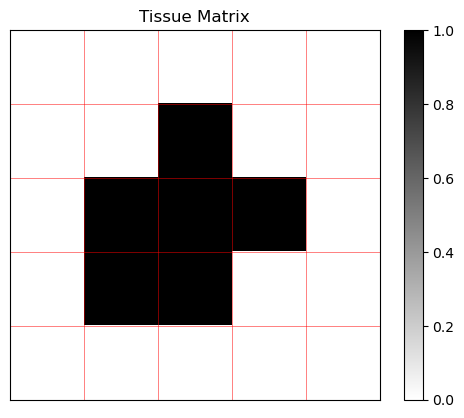

Optimal value: 600.1312320294902
Optimal solution: [  0.           0.           0.          52.77400072   0.
   0.           0.         134.98588076   0.           0.
   0.           0.         117.85873501   0.           0.
   0.          82.21188004  31.20769426   0.           0.        ]


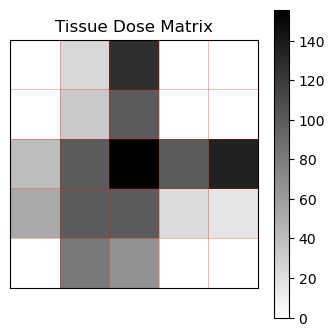

Average dose to tumor cells: 109.32
Average dose to healthy cells: 31.59


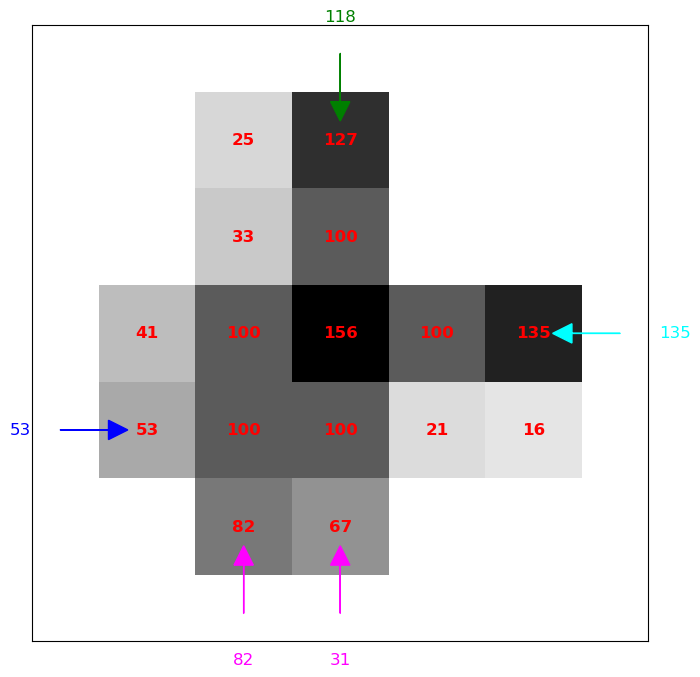

In [16]:
# test the class
tissue_matrix = np.array([[0, 0, 0, 0, 0],
                           [0, 0, 1, 0, 0],   
                           [0, 1, 1, 1, 0],
                           [0, 1, 1, 0, 0],
                           [0, 0, 0, 0, 0]])

# tissue_matrix = np.array([[0, 0, 0,],
#                            [0, 1, 0],
#                            [0,1,1]])

MaxDoseHealthyCells = None
tissue_irradiation = TissueIrradiationExponential(tissue_matrix, max_dose_healthy=MaxDoseHealthyCells, lam=0.3)
tissue_irradiation.plot_tissue()
tissue_irradiation.optimize(doReport=True)
tissue_irradiation.plot_irradiation()
tissue_irradiation.report_statistics()
# Plot dose distribution with beams
tissue_irradiation.plot_dose_distribution()


In [ ]:
class TissueIrradiationExponential:
    def __init__(self, tissue_matrix, min_dose_tumor=100, max_dose_healthy=None,lam=1):
        self.tissue_matrix = np.array(tissue_matrix)
        self.min_dose_tumor = min_dose_tumor
        self.max_dose_healthy = max_dose_healthy
        self.nrows, self.ncols = self.tissue_matrix.shape
        self.lam = lam  # mean free path of photons
        self.cmap = colors.LinearSegmentedColormap.from_list('custom_bw', ['white', 'black'])
        self._count_cells()
        self._build_c_minimize()
        self._find_indices_and_beam_matrices()
        self.optimized = False

    def plot_tissue(self):
        plt.imshow(self.tissue_matrix, cmap=self.cmap, interpolation='nearest', vmin=0, vmax=1)
        plt.colorbar()
        plt.title('Tissue Matrix')
        ax = plt.gca()
        ax.set_xticks(np.arange(-0.5, self.ncols, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, self.nrows, 1), minor=True)
        ax.grid(which='minor', color='red', linestyle='-', linewidth=0.7, alpha=0.5)
        ax.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
        plt.show()

    def _count_cells(self):
        self.healthy_in_rows = np.sum(self.tissue_matrix == 0, axis=1)
        self.healthy_in_cols = np.sum(self.tissue_matrix == 0, axis=0)
        self.tumor_in_rows = np.sum(self.tissue_matrix == 1, axis=1)
        self.tumor_in_cols = np.sum(self.tissue_matrix == 1, axis=0)

    def _build_c_minimize(self):
        # Minimize total dose to healthy cells
        # now we have exponential contributions from beams
        c_left,c_right  = np.zeros(self.nrows), np.zeros(self.nrows)
        c_above, c_under = np.zeros(self.ncols), np.zeros(self.ncols)
        for i in range(self.nrows):
            js = np.argwhere(self.tissue_matrix[i, :] == 0).flatten()
            c_left[i] = np.sum(np.exp(-self.lam * js))
            c_right[i] = np.sum(np.exp(-self.lam * (self.ncols - js - 1)))
        for j in range(self.ncols):
            is_ = np.argwhere(self.tissue_matrix[:, j] == 0).flatten()
            c_above[j] = np.sum(np.exp(-self.lam * is_))
            c_under[j] = np.sum(np.exp(-self.lam * (self.nrows - is_ - 1)))


    def _find_indices_and_beam_matrices(self):
        matrix = self.tissue_matrix
        tumor_positions = np.argwhere(matrix == 1)
        healthy_positions = np.argwhere(matrix == 0)
        n_beams = self.nrows + self.ncols

        tumor_beam_matrix = np.zeros((len(tumor_positions), n_beams), dtype=int)
        for idx, (i, j) in enumerate(tumor_positions):
            tumor_beam_matrix[idx, i] = 1
            tumor_beam_matrix[idx, self.nrows + j] = 1

        healthy_beam_matrix = np.zeros((len(healthy_positions), n_beams), dtype=int)
        for idx, (i, j) in enumerate(healthy_positions):
            healthy_beam_matrix[idx, i] = 1
            healthy_beam_matrix[idx, self.nrows + j] = 1

        self.tumor_positions = tumor_positions
        self.healthy_positions = healthy_positions
        self.tumor_beam_matrix = tumor_beam_matrix
        self.healthy_beam_matrix = healthy_beam_matrix

    def optimize(self,doReport =False):
        # Constraints for tumor cells (at least min_dose_tumor)
        Aub_tumor = -self.tumor_beam_matrix
        bub_tumor = -np.ones(self.tumor_beam_matrix.shape[0]) * self.min_dose_tumor
        # Constraints for healthy cells (at most max_dose_healthy)
        if self.max_dose_healthy is not None:
            Aub_healthy = self.healthy_beam_matrix
            bub_healthy = np.ones(self.healthy_beam_matrix.shape[0]) * self.max_dose_healthy
            Aub = np.vstack((Aub_tumor, Aub_healthy))
            bub = np.concatenate((bub_tumor, bub_healthy))
        else:
            Aub = Aub_tumor
            bub = bub_tumor
        bounds = [(0, None)] * len(self.c_minimize)

        result = linprog(c=self.c_minimize, A_ub=Aub, b_ub=bub, bounds=bounds, method='highs')
        self.result = result
        if result.success:
            print("Optimization successful.")
            self.optimal_beam_intensities = result.x
            self.DH_tot = result.fun
            self.optimized = True
            if doReport:
                print("Optimal value:", result.fun)
                print("Optimal solution:", result.x)    

        else:
            print("Optimization failed:", result.message)
            self.optimal_beam_intensities = None
            self.DH_tot = None
            self.optimized = False

    def plot_irradiation(self):
        if not self.optimized:
            print("Run optimize() first.")
            return
        # Calculate dose matrix
        dose_matrix = np.zeros_like(self.tissue_matrix, dtype=float)
        for i in range(self.nrows):
            for j in range(self.ncols):
                dose_matrix[i, j] = self.optimal_beam_intensities[i] + self.optimal_beam_intensities[self.nrows + j]
        self.tissue_dose_matrix = dose_matrix

        cmap_bw = colors.LinearSegmentedColormap.from_list('custom_bw', ['white', 'black'])
        plt.figure(figsize=(4, 4))
        plt.imshow(dose_matrix, cmap=cmap_bw, interpolation='nearest', vmin=np.min(dose_matrix), vmax=np.max(dose_matrix))
        plt.colorbar()
        plt.title('Tissue Dose Matrix')
        ax = plt.gca()
        ax.set_xticks(np.arange(-0.5, self.ncols, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, self.nrows, 1), minor=True)
        ax.grid(which='minor', color='red', linestyle='-', linewidth=0.7, alpha=.3)
        ax.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
        plt.show()


    def plot_dose_distribution(self):
        if not hasattr(self, 'tissue_dose_matrix'):
            print("Run plot_irradiation() first.")
            return
        fig, ax = plt.subplots(figsize=(8, 8))
        im = ax.imshow(self.tissue_dose_matrix, cmap=self.cmap, interpolation='nearest', vmin=0, vmax=np.max(self.tissue_dose_matrix))

        # Annotate each cell with its dose (if nonzero)
        for i in range(self.nrows):
            for j in range(self.ncols):
                dose = self.tissue_dose_matrix[i, j]
                if dose > 0:
                    ax.text(j, i, f"{dose:.0f}", ha='center', va='center', color='red', fontsize=12, fontweight='bold')

        # Draw beams: horizontal (rows) and vertical (cols)
        for beam_idx in range(self.nrows):
            intensity = self.optimal_beam_intensities[beam_idx] if hasattr(self, 'optimal_beam_intensities') else None
            if intensity is not None and intensity > 0:
                ax.arrow(-0.9, beam_idx, 0.5, 0, head_width=0.2, head_length=0.2, fc='blue', ec='blue', linewidth=1)
                ax.text(-1.2, beam_idx, f"{intensity:.0f}", va='center', ha='right', color='blue', fontsize=12)
        for beam_idx in range(self.ncols):
            intensity = self.optimal_beam_intensities[self.nrows + beam_idx] if hasattr(self, 'optimal_beam_intensities') else None
            if intensity is not None and intensity > 0:
                ax.arrow(beam_idx, -0.9, 0, 0.5, head_width=0.2, head_length=0.2, fc='green', ec='green', linewidth=1)
                ax.text(beam_idx, -1.2, f"{intensity:.0f}", va='bottom', ha='center', color='green', fontsize=12)

        #plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        #plt.title('Dose Distribution in Tissue (with Beams)')
        plt.xticks([])
        plt.yticks([])
        #plt.tight_layout()
        plt.show()

    def report_statistics(self):
        if not hasattr(self, 'tissue_dose_matrix'):
            print("Run plot_irradiation() first.")
            return
        tumor_mask = (self.tissue_matrix == 1)
        healthy_mask = (self.tissue_matrix == 0)
        avg_dose_tumor = self.tissue_dose_matrix[tumor_mask].mean() if np.any(tumor_mask) else 0
        avg_dose_healthy = self.tissue_dose_matrix[healthy_mask].mean() if np.any(healthy_mask) else 0
        print(f"Average dose to tumor cells: {avg_dose_tumor:.2f}")
        print(f"Average dose to healthy cells: {avg_dose_healthy:.2f}")


Third method: get dose fractions to tissue pixels from simulation of photon irradiation
---


...

---
# Finish

-------------------------------------------------------------

# For older code from 2022; look at:
 * directory /c/FAKS/MAGISTERIJ/MODELSKA_ANALIZA_1/MA1 naloge/_2_Linearno
 *  file **ObsevanjeTumorja.ipynb**

-----------------------------------------------------

-----------------------------------------------------